# Multiclass Classification Model Optimization Experiments
* Notebook by Adam Lang
* Date: 11/4/2024

# Overview
* This is a notebook of multiclass classification supervised machine learning models that I trained and aimed to optimize around a specific dataset.
* Supervised models used:
  * Logistic Regression
  * XGBoost
  * SVM
  * Naive Bayes


# Data Quality
* The significant issue with the data in this notebook is that there was signfificant imbalance in the target classes as well as high subjectivity and variability in the target labels.
* The end result was to pursue other modeling approaches such as:
  * Multilabel classification using Supervised Machine Learning
  * Transformer based multilabel classification
  * LLM based approaches

# Import Dependencies/Libraries

In [ ]:
## standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm
import html

import re
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import names

## machine learning imports
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

# Upload Pickled Dataset -- Train/Test split
* This is the dataset with train/test split based on the standard split that Matt and I are both going to test against.

In [ ]:
## pickled data path
train_data_path_pkle = <path to your data>
test_data_path_pkle = <path to your data>

In [ ]:
## upload train and test set
train_data = pd.read_pickle(train_data_path_pkle)
test_data = pd.read_pickle(test_data_path_pkle)

In [ ]:
## train data
test_data.tail(5)

text  y_true
508  thank for one team behavior support environmen...      10
509  thank you for help we brand our acc focus comm...       3
510  I want to thank you for the hard work and comm...       5
511  outstanding work in oulu soc lab action during...       8
512  thank you jean joel for your precious help in ...      11

In [ ]:
## test_data
test_data.head()

text  y_true
0  massive thank you for all your help and suppor...       2
1  belinda thank you for assist with the sow trai...       2
2  jonathan thank you for all of your translation...       2
3  thank you all for help through out the day wit...       2
4  we be very proud to have dave cox as our ehs m...      10

In [ ]:
## print len
print(f"Shape of train_data: {train_data.shape}")
print(f"Shape of test_data: {test_data.shape}")

Shape of train_data: (2196, 2)
Shape of test_data: (513, 2)


# EDA on Train/Test split data

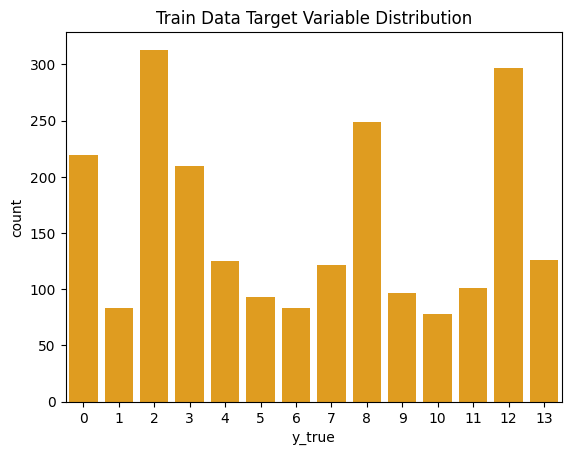

In [ ]:
## train data target variable count plot
sns.countplot(x=train_data['y_true'],data=train_data,color='orange').set(title="Train Data Target Variable Distribution")
plt.show();

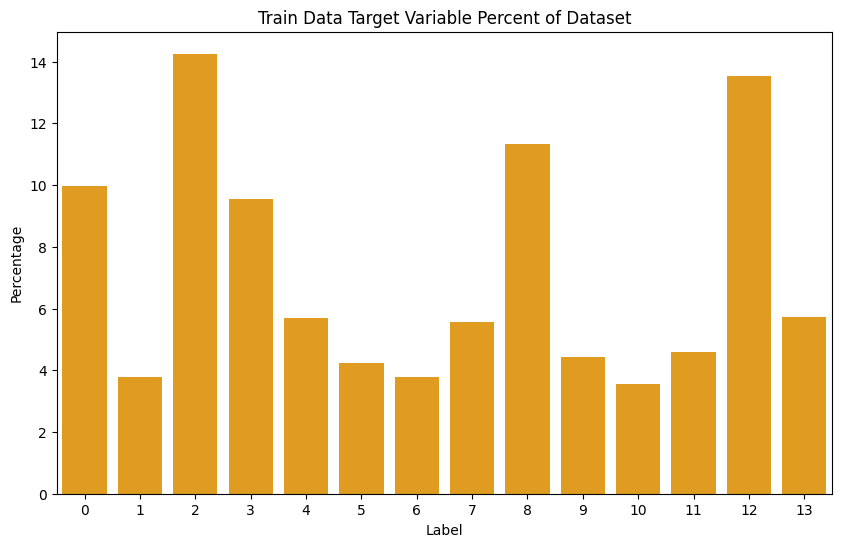

In [ ]:
# Calculate percentages (same as before)
label_percentages = (train_data['y_true'].value_counts(normalize=True) * 100).reset_index()
label_percentages.columns = ['Label', 'Percentage']

# Create bar plot with switched axes
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.barplot(x='Label', y='Percentage', data=label_percentages, color="orange")
plt.title("Train Data Target Variable Percent of Dataset")
plt.ylabel("Percentage")  # Updated ylabel
plt.xlabel("Label")  # Updated xlabel
plt.show();

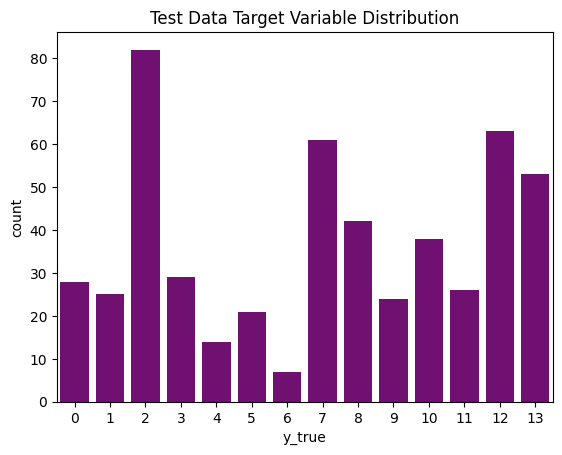

In [ ]:
## test data target var count plot
sns.countplot(x=test_data['y_true'],data=test_data,color="purple").set(title="Test Data Target Variable Distribution")
plt.show();

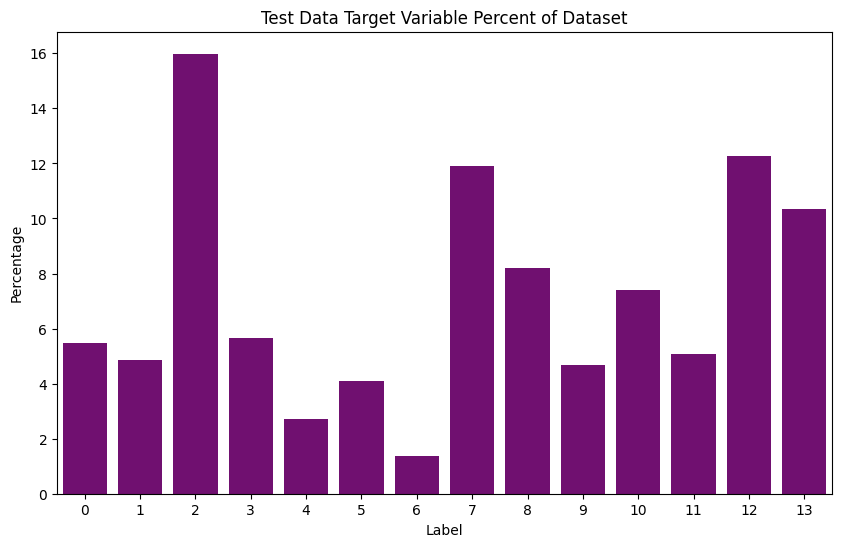

In [ ]:
## percentage of test data
# Calculate percentages (same as before)
label_percentages = (test_data['y_true'].value_counts(normalize=True) * 100).reset_index()
label_percentages.columns = ['Label', 'Percentage']

# Create bar plot with switched axes
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
sns.barplot(x='Label', y='Percentage', data=label_percentages, color="purple")
plt.title("Test Data Target Variable Percent of Dataset")
plt.ylabel("Percentage")  # Updated ylabel
plt.xlabel("Label")  # Updated xlabel
plt.show();

# Oversampling - Dealing with Imbalanced target class
* As we see above the target class is imbalanced.
* There are mulitple ways to handle this, we will utilize a technique and see if it improves the models which I bet it will.
* I will first try implementing and oversampling algorithm - “ADASYN”.
    * ADASYN or Adaptive Synthetic Sampling is a SMOTE algorithm that tries to oversample the minority data based on the data density.
    * ADASYN assigns a weighted distribution to each of the minority samples and prioritize oversampling to the minority samples that are harder to learn.
    * SMOTE and ADASYN generate new samples in by interpolation.
    * However, samples used to interpolate/generate new synthetic samples differ.

* ADASYN focuses on generating samples next to the original samples which are wrongly classified using a k-Nearest Neighbors classifier while the basic implementation of SMOTE will not make any distinction between easy and hard samples to be classified using the nearest neighbors rule.
* Therefore, the decision function found during training will be different among the algorithms.

References:
1. sci-kit learn: https://imbalanced-learn.org/stable/over_sampling.html
2. 7 types of SMOTE: https://www.kdnuggets.com/2023/01/7-smote-variations-oversampling.html


In [ ]:
#!pip install -U scikit-learn
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer  # For text to numerical
import pandas as pd

# Load your dataset
imbal_data = train_data

# Separate features and target variable
X = imbal_data['text']  # Now X is just the 'text' column
y = imbal_data['y_true']

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Print the class distribution before oversampling
print("Class distribution before oversampling:")
print(Counter(y))



Class distribution before oversampling:
Counter({2: 313, 12: 297, 8: 249, 0: 219, 3: 210, 13: 126, 4: 125, 7: 122, 11: 101, 9: 97, 5: 93, 1: 83, 6: 83, 10: 78})


In [ ]:
# Convert text data to numerical using TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X) # Fit and transform the text data

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, y)

# Print the class distribution after SMOTE oversampling
print("\nClass distribution after SMOTE oversampling:")
print(Counter(y_smote))

# Apply ADASYN for oversampling
adasyn = ADASYN(random_state=42, sampling_strategy='minority')  # Change sampling_strategy
X_adasyn, y_adasyn = adasyn.fit_resample(X_tfidf, y)

# Print the class distribution after ADASYN oversampling
print("\nClass distribution after ADASYN oversampling:")
print(Counter(y_adasyn))


Class distribution after SMOTE oversampling:
Counter({1: 313, 7: 313, 13: 313, 2: 313, 8: 313, 11: 313, 4: 313, 12: 313, 9: 313, 6: 313, 10: 313, 0: 313, 5: 313, 3: 313})

Class distribution after ADASYN oversampling:
Counter({2: 313, 10: 302, 12: 297, 8: 249, 0: 219, 3: 210, 13: 126, 4: 125, 7: 122, 11: 101, 9: 97, 5: 93, 1: 83, 6: 83})


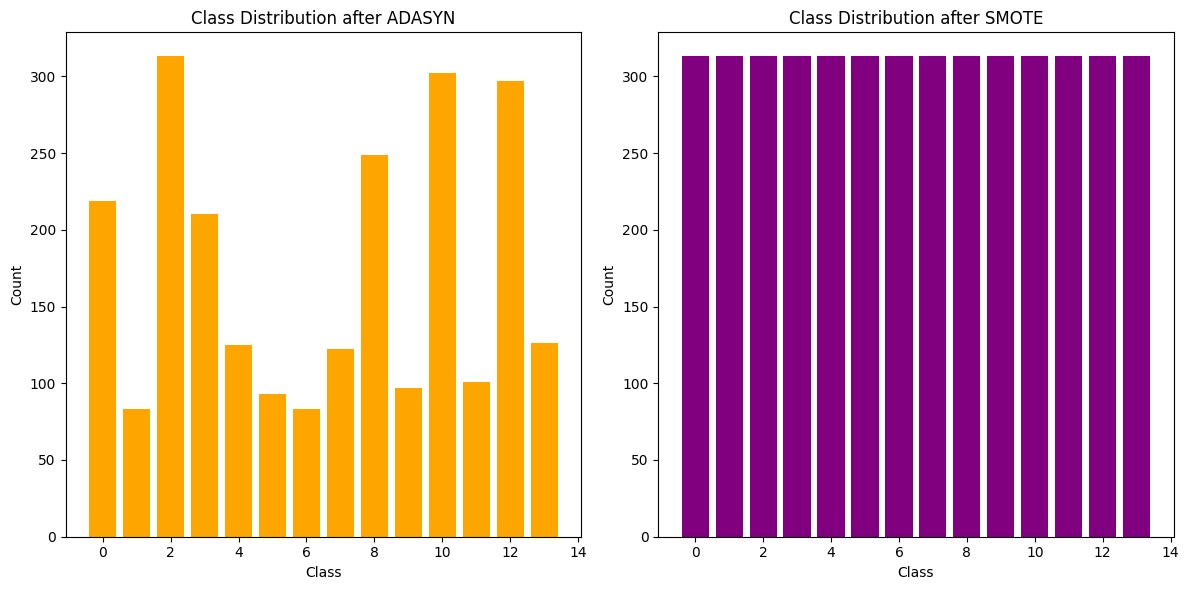

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot for ADASYN
axes[0].bar(Counter(y_adasyn).keys(), Counter(y_adasyn).values(), color='orange')
axes[0].set_title('Class Distribution after ADASYN')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Count')

# Plot for SMOTE
axes[1].bar(Counter(y_smote).keys(), Counter(y_smote).values(), color='purple')
axes[1].set_title('Class Distribution after SMOTE')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Count')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

Summary:
* We can see that ADASYN did not do much at all to change the distributions of the classes.
* The goal was oversampling so we will go with the SMOTE result.

# Upload Dataset -- this code is not needed anymore
* Previously we uploaded data and tried to duplicate the previous experiment's train/test splits but due to some confusion in the methodology, we decided instead to upload a dataset above with a train/test split as 2 separate datasets.

In [ ]:
## path to data
data_path = <path to your data>

In [ ]:
## upload data
df = pd.read_csv(data_path, index_col=0)

## df sample
df.sample(10)

text  \
17    Theresa - you are always so quick to take on a...   
24    As we are wrapping up this year I have been re...   
35    Jeff, Thanks for your time and support during ...   
194   You contributions, leadership of the team, and...   
716   Hi Pat. I just wanted to let you know how than...   
1067  Sharing experiences and data validates the sit...   
745   Hi Jess, cheers to your 1st Anniversary as Reg...   
865   Thank you for all your hard work and great sup...   
174   Dear D&I TED talk leads, I want to congratulat...   
373   I wanted to thank and recognise your engagemen...   

                                label                     resource  
17                     supportiveness                    1K random  
24                         leadership                   from skill  
35                     supportiveness                    1K random  
194                        leadership                      1K 6cat  
716                    supportiveness                    1K random  
1067   innovation and problem solving                   from skill  
745                    general thanks                    1K random  
865   expertise and knowledge sharing                      1K 6cat  
174                           dei esg  minority class augmentation  
373                        work ethic                      1K 6cat

# Exploratory Analysis

In [ ]:
## view columns
df.columns

Index(['text', 'label', 'resource'], dtype='object')

In [ ]:
## df info
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2709 entries, 0 to 1271
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      2709 non-null   object
 1   label     2709 non-null   object
 2   resource  2709 non-null   object
dtypes: object(3)
memory usage: 84.7+ KB


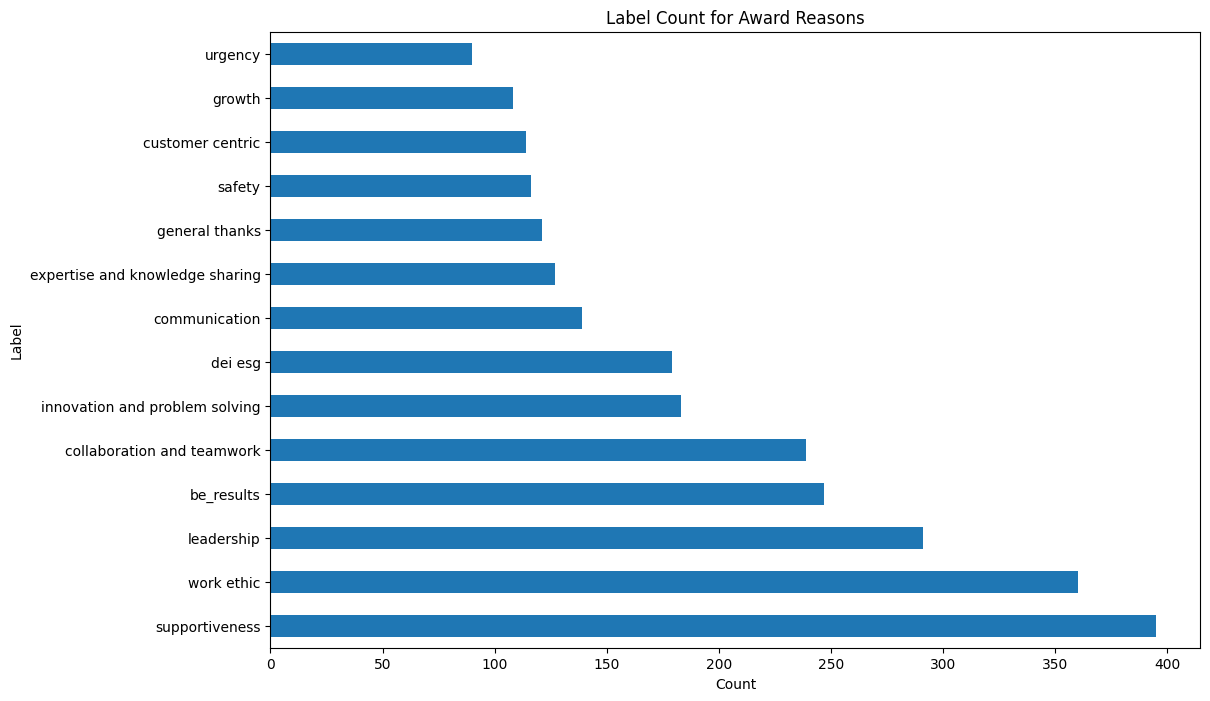

In [ ]:
## label value counts
fig = plt.figure(figsize=(12,8))
df['label'].value_counts().plot(kind='barh')
plt.title("Label Count for Award Reasons")
plt.xlabel("Count")
plt.ylabel("Label")
plt.show();


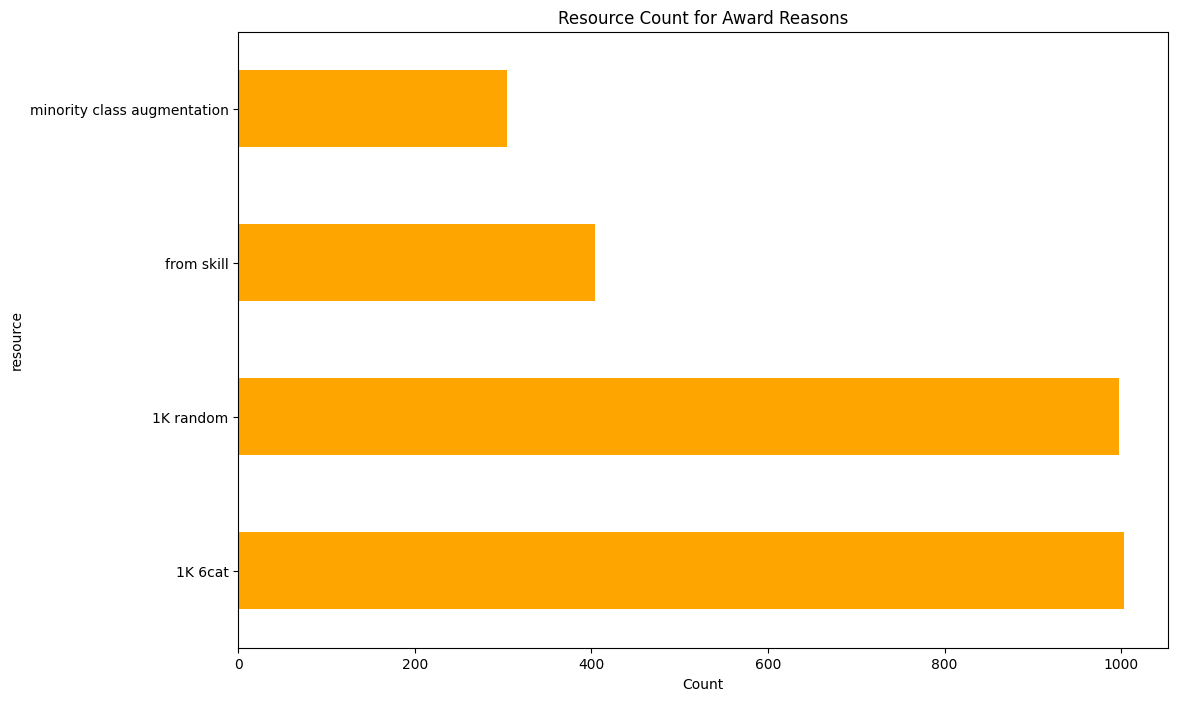

In [ ]:
## resource value counts
fig = plt.figure(figsize=(12,8))
df['resource'].value_counts().plot(kind='barh',color='orange')
plt.title("Resource Count for Award Reasons")
plt.xlabel("Count")
plt.show();


In [ ]:
### Following previous experiments' original notebook code
### move 'safety' and 'innovation' data from soft skill to training to boost this sparse category
increased_test_data = df[df['label'].isin(['safety', 'innovation and problem solving'])]
increased_test_data['resource']='1K random'

<ipython-input-140-0d874ab3e18b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  increased_test_data['resource']='1K random'


In [ ]:
## following previous experiment's original notebook code
## other data
other_data = df[~df['label'].isin(['safety', 'innovation and problem solving'])]

In [ ]:
## final data
data = pd.concat([other_data, increased_test_data])

In [ ]:
## data head
data.head()

text             label  \
1  Thank you X 10000000!! You are soooo Helpful A...    supportiveness   
2  Hi Sudha, Thanks for being very key member for...    general thanks   
3  All, as we wrap up EAW week, I want to share m...    general thanks   
4  Thank you Jen and Kathy for helping and planni...    supportiveness   
5  Thank you, Xiaosheng, for your compassion in r...  customer centric   

    resource  
1  1K random  
2  1K random  
3  1K random  
4  1K random  
5  1K random

In [ ]:
## check resources
data['resource'].value_counts()

resource
1K random                      1247
1K 6cat                         917
minority class augmentation     305
from skill                      240
Name: count, dtype: int64

In [ ]:
## check labels
data['label'].value_counts()

label
supportiveness                     395
work ethic                         360
leadership                         291
be_results                         247
collaboration and teamwork         239
innovation and problem solving     183
dei esg                            179
communication                      139
expertise and knowledge sharing    127
general thanks                     121
safety                             116
customer centric                   114
growth                             108
urgency                             90
Name: count, dtype: int64

In [ ]:
## data len
len(data)

2709

Summary:
* I cross checked this with original experiment notebook and all values are the same so far.

In [ ]:
## label groupby
data.groupby(['label','resource']).size()

label                            resource                   
be_results                       1K 6cat                        162
                                 1K random                       85
collaboration and teamwork       1K 6cat                         64
                                 1K random                       88
                                 from skill                      86
                                 minority class augmentation      1
communication                    1K 6cat                         44
                                 1K random                       42
                                 from skill                      53
customer centric                 1K 6cat                         51
                                 1K random                       63
dei esg                          1K 6cat                          1
                                 1K random                        8
                                 from skill                      17
                                 minority class augmentation    153
expertise and knowledge sharing  1K 6cat                         48
                                 1K random                       49
                                 minority class augmentation     30
general thanks                   1K 6cat                         50
                                 1K random                       70
                                 minority class augmentation      1
growth                           1K 6cat                         33
                                 1K random                       18
                                 minority class augmentation     57
innovation and problem solving   1K random                      183
leadership                       1K 6cat                         79
                                 1K random                      127
                                 from skill                      84
                                 minority class augmentation      1
safety                           1K random                      116
supportiveness                   1K 6cat                        146
                                 1K random                      240
                                 minority class augmentation      9
urgency                          1K 6cat                         68
                                 1K random                       21
                                 minority class augmentation      1
work ethic                       1K 6cat                        171
                                 1K random                      137
                                 minority class augmentation     52
dtype: int64

# START HERE

# Helper Functions

In [ ]:
## data labels
labels = {'be_results':0,
          # 'be_drive':1,
          'growth':1,
          'supportiveness':2,
          'collaboration and teamwork':3,
          'communication':4,
          'customer centric':5,
          'urgency':6,
          'innovation and problem solving':7,
          'leadership':8,
          'general thanks':9,
          'safety':10,
         'expertise and knowledge sharing': 11,
         'work ethic': 12,
         'dei esg': 13}

# Text Preprocessing -- NOT NEEDED IF USING PRE-SPLIT TRAIN/TEST DATA

In [ ]:
## Customize stopwords for vectorization - this is a curated list from the previous experiments stop words list removed
## using TFIDF

import nltk
from nltk.corpus import stopwords

customized_stopwords = ['thank', 'congratulation', 'appreciate', 'grateful', 'appreciation', 'month', 'year',
                        'week', 'day', 'great', 'good', 'able', 'make', 'lot', 'know', 'hi', 'hello', 'just',
                        'best', 'really', 'say', 'sure', 'bp', 'truly', 'like', 'amazig', 'awesome', 'come',
                        'star', 'gem']
nltk.download('stopwords')
stopwords = stopwords.words('english')
stopwords.extend(customized_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
## using previous experiment's original function to maintain standardization

## load spacy
nlp = spacy.load('en_core_web_sm')
nlp.remove_pipe('ner')

## preprocessing of text
def text_preprocessing(df):
    df['text'] = df['text'].apply(lambda text: html.unescape(text))
    df['text_cleaned'] = df['text'].apply(lambda x: re.sub("[^A-Za-z']+", ' ', str(x)).lower())
    df['text_lemma'] = df['text_cleaned'].apply(lambda sent: ' '.join([i.lemma_ for i in nlp(sent)]))

    # Remove stop words from 'text_lemma' using your extended stopwords list
    df['text_lemma'] = df['text_lemma'].apply(lambda text: ' '.join([word for word in text.split() if word.lower() not in stopwords]))  # Use 'stopwords' directly


    return df

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


# Label Mapping -- NOT NEEDED IF USING PRE SPLIT TRAIN/TEST DATA
* We need to map the labels to the data

In [ ]:
## add id2label mapping
data['label_num'] = data['label'].map(labels)

# Apply Text Processing Function -- NOT NEEDED IF USING PRE SPLIT TRAIN/TEST DATA

In [ ]:
## apply previous experiment's preprocess function to data
data = text_preprocessing(data)

In [ ]:
## data head
data.head()

text             label  \
1  Thank you X 10000000!! You are soooo Helpful A...    supportiveness   
2  Hi Sudha, Thanks for being very key member for...    general thanks   
3  All, as we wrap up EAW week, I want to share m...    general thanks   
4  Thank you Jen and Kathy for helping and planni...    supportiveness   
5  Thank you, Xiaosheng, for your compassion in r...  customer centric   

    resource  label_num                                       text_cleaned  \
1  1K random          2  thank you x you are soooo helpful all the time...   
2  1K random          9  hi sudha thanks for being very key member for ...   
3  1K random          9  all as we wrap up eaw week i want to share my ...   
4  1K random          2  thank you jen and kathy for helping and planni...   
5  1K random          5  thank you xiaosheng for your compassion in res...   

                                          text_lemma  
1  x soooo helpful time would help many client wi...  
2  sudha key member volvo truck qa activity prime...  
3  wrap eaw want share sincere every real honor w...  
4  jen kathy help plan logistic ipc specialist ce...  
5  xiaosheng compassion response cultural consult...

# Open Source Embedding Models
* We will use this a reference, however when creating embeddings we will have to modify the function.
* Embedding Models we can test, small to large:

1. 'sentence-transformers/paraphrase-MiniLM-L6-v2'
    * Max Sequence Length: 128
    * Dimensions: 384
    
2. `sentence-transformers/paraphrase-mpnet-base-v2`
    * Max Sequence Length: 512
    * Dimensions:	768

2a. `sentence-transformers/all-mpnet-base-v2`
    * Max Sequence Length: 384
    * Dimensions: 768

3. `mixedbread-ai/mxbai-embed-large-v1`
    * Max Sequence Length: 512
    * Dimensions: 1024

4. `mixedbread-ai/mxbai-embed-xsmall-v1`
    * Max Sequence Length: 4096
    * Dimensions: 384
    * **Note: Based on sentence-transformers/all-MiniLM-L6-v2, this model has only 22.7 million parameters and is trained in float16 for efficiency.**

5. `jinaai/jina-embeddings-v2-small-en`
    * Max Sequence Length: 8192
    * Dimensions: 512

6. `nvidia/NV-Embed-v2` <==== NOT USING, MODEL IS TOO BIG TO LOAD
  * Max Sequence Length: 512
  * Dimensions: 4096
  * **Note: This is the #1 ranked model on the MTEB for all embeddings as well as all classification specific tasks. Worth a try.**
  * **Note: Base Decoder-only LLM: Mistral-7B-v0.1**
    * Pooling Type: Latent-Attention

7. `prithivida/Splade_PP_en_v2`
  * Max Sequence Length: 512
  * Dimensions: 768
  * **Note: This is a sparse embedding model. Since the current logistic regression model performs well with TF-IDF sparse vectors this approach is worth trying.**

8. `Alibaba-NLP/gte-Qwen2-7B-instruct`
  * Max Sequence Length: 32768
  * Dimensions: n/a
  * to use model: model = SentenceTransformer("Alibaba-NLP/gte-Qwen2-7B-instruct", trust_remote_code=True)
* Note: This is the Qwen LLM decoder model that was transformed via llm2vec to an encoder model to create embeddings.

In [ ]:
!pip install sentence-transformers

In [ ]:
!pip install flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 54.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for flash-attn: filename=flash_attn-2.7.0.post2-cp310-cp310-linux_x86_64.whl size=183278540 sha256=eb4eb73682931a7c591a97ff12926b392ebea4c67e8d9846537925fbfcddaecf
  Stored in directory: /root/.cache/pip/wheels/bf/e3/ed/5e845387d52f2debd1bafb847bf3d774d3f0a3c8e31b1dc948
Successfully built flash-attn


In [ ]:
from sentence_transformers import SentenceTransformer

qwen_model = SentenceTransformer("Alibaba-NLP/gte-Qwen2-7B-instruct", trust_remote_code=True)


model.safetensors.index.json:   0%|          | 0.00/27.8k [00:00<?, ?B/s]

model-00001-of-00007.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00007.safetensors:   0%|          | 0.00/4.78G [00:00<?, ?B/s]

model-00003-of-00007.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00007.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00005-of-00007.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00006-of-00007.safetensors:   0%|          | 0.00/3.66G [00:00<?, ?B/s]

model-00007-of-00007.safetensors:   0%|          | 0.00/2.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

tokenization_qwen.py:   0%|          | 0.00/10.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/Alibaba-NLP/gte-Qwen2-7B-instruct:
- tokenization_qwen.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/80.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/370 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 260.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 79.06 MiB is free. Process 6353 has 14.67 GiB memory in use. Of the allocated memory 14.49 GiB is allocated by PyTorch, and 79.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
from sentence_transformers import SentenceTransformer

## embedding models
model1 = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

model2 = SentenceTransformer('sentence-transformers/paraphrase-mpnet-base-v2')

model3 = SentenceTransformer("mixedbread-ai/mxbai-embed-xsmall-v1")

model4 = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")


/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/81.0k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/675 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/48.2M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
## add more models here
model5 = SentenceTransformer("jinaai/jina-embeddings-v2-small-en", trust_remote_code=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/117 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/70.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

configuration_bert.py:   0%|          | 0.00/8.24k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_bert.py:   0%|          | 0.00/97.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/jina-bert-implementation:
- modeling_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/65.4M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
## nvidia model requires datasets from HF
#!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
## upgrade transformers ---> NEEDED TO RUN NVIDIA MODEL
#!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 35.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


### NVIDIA model is TOO BIG to load so not using right now

In [ ]:
#from sentence_transformers import SentenceTransformer
## nvidia model
#model6 = SentenceTransformer("nvidia/NV-Embed-v2", trust_remote_code=True)

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM


## function to create splade embeddings
def splade_emb(text):
  """
  Generates embeddings using the Splade model.

  Args:
    text: The input text to embed.

  Returns:
    A NumPy array containing the embedding.
  """
  # Initialize tokenizer and model
  tokenizer = AutoTokenizer.from_pretrained("prithivida/Splade_PP_en_v2")
  model = AutoModelForMaskedLM.from_pretrained("prithivida/Splade_PP_en_v2")

  # Tokenize text and create embeddings
  inputs = tokenizer(text, return_tensors="pt")
  ## pass output_hidden=True to get hidden states
  outputs = model(**inputs, output_hidden_states=True)

  # Get the embeddings (hidden states)
  embeddings = outputs.hidden_states[-1][:, 0, :].detach().numpy()  # Last hidden state, CLS token

  return embeddings

In [ ]:
## test out function
splade_emb("Hello I love skiing.")

array([[-6.73675686e-02,  4.05648649e-02,  7.24637985e-01,
         4.48287100e-01, -1.57082468e-01,  1.69807807e-01,
         5.90024054e-01,  1.42893195e-01, -6.18609786e-01,
        -5.39320529e-01, -5.70784152e-01,  2.18518555e-01,
         1.73210517e-01,  2.23183095e-01,  3.21897656e-01,
         2.81622499e-01,  1.52704656e-01, -1.71281084e-01,
         5.40126801e-01, -4.72379506e-01, -5.90835929e-01,
        -2.18175724e-01,  4.08846915e-01, -4.19114262e-01,
        -2.96411570e-02,  1.69681937e-01,  7.05177635e-02,
        -2.08858773e-01, -3.62876445e-01,  5.02433479e-01,
        -2.64855903e-02, -3.58508080e-02,  5.53322732e-01,
        -2.87405372e-01, -8.10044408e-01, -7.63472095e-02,
        -4.70928669e-01, -3.86397727e-03, -5.24154305e-03,
        -5.79741180e-01,  6.32541478e-01,  2.43497312e-01,
         1.72095886e-03,  1.88183449e-02, -5.57651401e-01,
        -1.37031451e-01, -2.47121334e+00,  1.58487335e-01,
        -6.18620217e-03, -9.13503885e-01, -5.70260406e-0

In [ ]:
## static embedding model
#model8 = SentenceTransformer("joshcx/static_embedding")

In [ ]:
## setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Logistic Regression Function
* This uses default parameters.

In [ ]:
## original train function
def train(train_data, test_data, embedding_model):
    """
    Trains a Logistic Regression model using embeddings.

    Args:
        train_data: DataFrame containing 'text' and 'y_true' columns for training.
        test_data: DataFrame containing 'text' and 'y_true' columns for testing.
        embedding_model: The embedding model to use.

    Returns:
        A tuple containing the trained classifier, train score, test score,
        predicted labels, predicted probabilities, and the confusion matrix.
    """
    ## 1. setup embedding model
    embed_model = embedding_model

    ## 2. Generate embeddings for train and val data
    x_train_feature = embed_model.encode(train_data['text'].to_list(),batch_size=64,show_progress_bar=True,convert_to_tensor=True, return_tensor='pt')
    x_test_feature = embed_model.encode(test_data['text'].to_list(), batch_size=64, show_progress_bar=True,convert_to_tensor=True, return_tensor='pt')

    ## 3. Machine Learning Classification Model Setup -- Logistic Regression
    ## These are the original parameters that were used
    classifier = LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=42, class_weight='balanced')
    classifier.fit(x_train_feature.cpu().numpy(), train_data['y_true']) #convert tensors to numpy arrays

    ## 4. obtain accuracy score for train and test sets
    train_score = classifier.score(x_train_feature.cpu().numpy(), train_data['y_true'])
    test_score = classifier.score(x_test_feature.cpu().numpy(), test_data['y_true'])

    ## 5. predict on test set
    y_test_pred = classifier.predict(x_test_feature.cpu().numpy())
    y_test_proba = classifier.predict_proba(x_test_feature.cpu().numpy())

    ## return confusion matrix
    cm = metrics.confusion_matrix(val_labels, y_test_pred)

    return classifier, train_score, test_score, y_test_pred, y_test_proba, cm

## New Logistic Regression Function

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

## logistic regression train function
def train(train_texts, train_labels, val_texts, val_labels, embedding_model):
    """
    Trains a classification model using SentenceTransformer embeddings.

    Args:
        train_texts: List of training texts.
        train_labels: List of training labels.
        val_texts: List of validation texts.
        val_labels: List of validation labels.
        embedding_model: SentenceTransformer model.

    Returns:
        Trained classifier, training accuracy, testing accuracy,
        predicted labels, predicted probabilities, and confusion matrix.
    """

    ## create embeddings
    train_embeddings = embedding_model.encode(train_texts, show_progress_bar=True)
    val_embeddings = embedding_model.encode(val_texts, show_progress_bar=True)

    ## train model --- using previous experiment's original default LR settings
    classifier = LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=42, class_weight='balanced')
    classifier.fit(train_embeddings, train_labels)

    ## evaluate model
    train_score = accuracy_score(train_labels, classifier.predict(train_embeddings))
    test_score = accuracy_score(val_labels, classifier.predict(val_embeddings))
    y_test_pred = classifier.predict(val_embeddings)
    y_test_proba = classifier.predict_proba(val_embeddings)
    cm = confusion_matrix(val_labels, y_test_pred)

    return classifier, train_score, test_score, y_test_pred, y_test_proba, cm

### XGBoost Function

In [ ]:
!pip install xgboost

In [ ]:
#!pip install xgboost
import xgboost as xgb

## xgboost train
def train_xgb(train_data, test_data, embedding_model):
    ## 1. split data into train and validation
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        train_data['text'], train_data['y_true'], test_size=0.2, random_state=42
    )



    ## 2. embed data
    train_embeddings = embedding_model.encode(train_texts, show_progress_bar=True)
    val_embeddings = embedding_model.encode(val_texts, show_progress_bar=True)
    test_embeddings = embedding_model.encode(test_data['text'], show_progress_bar=True)


    ## 3. Machine Learning Classification Model Setup -- XGBoost
    # Convert tensors to numpy arrays before using with XGBoost
    x_train_np = x_train_feature.cpu().numpy()
    x_test_np = x_test_feature.cpu().numpy()

    # Define XGBoost classifier with parameters
    # You might need to adjust these parameters based on your dataset
    classifier = xgb.XGBClassifier(
        objective='multi:softmax',  # for multi-class classification
        num_class=len(set(train_data['y_true'])), # number of classes
        n_estimators=100,  # number of trees
        max_depth=3,       # maximum depth of each tree
        learning_rate=0.1, # learning rate
        random_state=42    # random seed for reproducibility
    )

    # Train the XGBoost classifier
    classifier.fit(x_train_np, train_data['y_true'])

    ## 4. obtain accuracy score for train and test sets
    train_score = classifier.score(x_train_feature.cpu().numpy(), train_data['y_true'])
    test_score = classifier.score(x_test_feature.cpu().numpy(), test_data['y_true'])

    ## 5. predict on test set
    y_test_pred = classifier.predict(x_test_feature.cpu().numpy())
    y_test_proba = classifier.predict_proba(x_test_feature.cpu().numpy())

    ## return confusion matrix
    cm = metrics.confusion_matrix(test_data['y_true'], y_test_pred)

    return classifier, train_score, test_score, y_test_pred, y_test_proba, cm

## New XGBoost Function

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

## new XGB function
def train_xgb(train_texts, train_labels, val_texts, val_labels, embedding_model):
    """
    Trains an XGBoost classification model using SentenceTransformer embeddings.

    Args:
        train_texts: List of training texts.
        train_labels: List of training labels.
        val_texts: List of validation texts.
        val_labels: List of validation labels.
        embedding_model: SentenceTransformer model.

    Returns:
        Trained XGBoost classifier, training accuracy, testing accuracy,
        predicted labels, predicted probabilities, and confusion matrix.
    """

    ## 1. Create embeddings
    train_embeddings = embedding_model.encode(train_texts, show_progress_bar=True)
    val_embeddings = embedding_model.encode(val_texts, show_progress_bar=True)

    ## 2. Machine Learning Classification Model Setup -- XGBoost
    # Define XGBoost classifier with parameters
    classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(set(train_labels)),  # Use 'label' instead of 'y_true'
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )

    # Train the XGBoost classifier using train_embeddings
    classifier.fit(train_embeddings, train_labels)

    ## 3. Obtain accuracy score for train and validation sets
    train_score = accuracy_score(train_labels, classifier.predict(train_embeddings))
    val_score = accuracy_score(val_labels, classifier.predict(val_embeddings))

    ## 4. Predict on validation set
    y_val_pred = classifier.predict(val_embeddings)
    y_val_proba = classifier.predict_proba(val_embeddings)

    ## 5. Return confusion matrix calculated on validation set
    cm = confusion_matrix(val_labels, y_val_pred)

    return classifier, train_score, val_score, y_val_pred, y_val_proba, cm

# Feature Engineering -- NOT NEEDED IF USING TRAIN/TEST DATASETS
* Previous experiment originally used 50% of '1K random' data for testing and then added data from other sources including '1K 6cat' and 'soft skill' for training.
* **We are going to use an 80/20 split instead.**

In [ ]:
## random annotate
random_annotate = data[data['resource']=='1K random']

## create train_test_split with 80/20 for train/test split --- keep random state 42
train_texts, val_texts, train_labels, val_labels = train_test_split(random_annotate['text_lemma'], random_annotate['label_num'], stratify=random_annotate['label_num'].to_numpy(), test_size=0.2, random_state=42)

In [ ]:
aug_data = data[data['resource']!='1K random']

aug_train_texts = pd.concat([train_texts, aug_data['text_lemma']])
aug_train_labels = pd.concat([train_labels, aug_data['label_num']])

In [ ]:
# shape of train, test, val
print(f"Shape of train_texts: {train_texts.shape}")
print(f"Shape of train_labels: {train_labels.shape}")
print(f"Shape of val_texts: {val_texts.shape}")
print(f"Shape of val_labels: {val_labels.shape}")
print(f"Shape of aug_train_texts: {aug_train_texts.shape}")
print(f"Shape of aug_train_labels: {aug_train_labels.shape}")

Shape of train_texts: (997,)
Shape of train_labels: (997,)
Shape of val_texts: (250,)
Shape of val_labels: (250,)
Shape of aug_train_texts: (2459,)
Shape of aug_train_labels: (2459,)


# SetFit Classification model

In [ ]:
train_data.head()

text  y_true
0  david thank for all the effort you have put fo...       1
1  lynsey you come back and it literally feel lik...       7
2  thank you both so much for your support and de...      13
3  caroline thank for host the amazing pub triviu...       7
4  thank you jimmy really appreciate your help wi...       2

In [ ]:
!pip install setfit --upgrade  # Try upgrading to the latest version of setfit

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# imports
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
import sentence_transformers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.set_fit import SetFit

ModuleNotFoundError: No module named 'sklearn.set_fit'

In [ ]:

# Load the pre-trained model
model = sentence_transformers.SentenceTransformer('paraphrase-mpnet-base-v2')

# Load the CSV dataset
#data = pd.read_csv('your_dataset.csv')

# Compute sentence embeddings
embeddings = model.encode(train_data['text'].tolist())

# Use the numerical labels directly (assuming the labels are in the 'label_column')
y = train_data['y_true'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

# Define the SetFit pipeline
set_fit = make_pipeline(
    make_column_transformer(
        (FunctionTransformer(None), slice(None)),
        remainder="drop"
    ),
    SetFit(
        OneVsRestClassifier(
            SVC(kernel="precomputed", probability=True)
        )
    ),
)

# Train the SetFit model
set_fit.fit(X_train, y_train)

# Make predictions on the train and test sets
y_train_pred = set_fit.predict(X_train)
y_test_pred = set_fit.predict(X_test)

# Calculate the accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracy scores
print(f'Train Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

# Rename val_labels (test set labels) to test_labels for clarity
test_labels = val_labels

# Print the classification report
print(classification_report(test_labels, y_test_pred, target_names=labels.keys()))

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


KeyboardInterrupt: 

# Model 1 Experiment -- ONLY adding embeddings
* We will use the existing Logistic Regression model but with an 80/20 train/test split intead of 50/50 as the initial model.
* We will try 2 separate embedding models and evaluate the results.
* The goal of this first approach is to see what happens when we use various embedding models vs. the original model which was TFIDF only as well as using an 80/20 split rather than 50/50 split.
* For the next set of experiments I will try hyperparameter optimization and k-folds cross validation with embeddings and see which model(s) end up being the best.

## Create data for experiment
* Based on previous experiments.

In [ ]:
### This snippet is originally from code for "Model 3": include training data from 1K 6cat and skill

### follow this framework for train/test split --- Matt using same approach for standardization
aug_data = data[data['resource'].isin(['1K 6cat', 'from skill'])]

## train text and labels
aug_train_texts = pd.concat([train_texts, aug_data['text_lemma']])
aug_train_labels = pd.concat([train_labels, aug_data['label_num']])



In [ ]:
len(aug_train_texts)

2154

In [ ]:
aug_train_texts.head()

345    shulin job propose hackday execute perfection ...
971    bernardo want wonderful work summarize improve...
894    fantastic work detect fix air leak work save s...
450    kelly teach much continue teach every take tim...
527    watch collaboration extraordinary work togethe...
Name: text_lemma, dtype: object

# Train/Test split

Oversampling SMOTE train/test split

In [ ]:
%%time
# split X_smote, y_smote into train and validation sets
# Split the train_data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)


CPU times: user 4.97 ms, sys: 3 µs, total: 4.98 ms
Wall time: 6.81 ms


Normal train/test split

In [ ]:
%%time
# Split the train_data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['text'], train_data['y_true'], test_size=0.2, random_state=42)


CPU times: user 4.2 ms, sys: 40 µs, total: 4.24 ms
Wall time: 4.25 ms


### Embedding Model 1
* 'sentence-transformers/paraphrase-MiniLM-L6-v2'
  * Max Sequence Length: 128
  * Dimensions: 384


#### Logistic Regression

In [ ]:
# Train the model
classifier_1, train_score_1, test_score_1, y_test_pred_1, y_test_proba_1, cm_1 = train(train_texts.to_numpy(), train_labels, val_texts.to_numpy(), val_labels, model1)

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels  # Assuming val_labels here is the one with 513 samples

## print results
print('Train score: ', train_score_1)
print('Test score: ', test_score_1)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_1:", y_test_pred_1.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_1, target_names=labels.keys()))

Train score:  0.7539863325740319
Test score:  0.38636363636363635
Shape of test_labels: (440,)
Shape of y_test_pred_1: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.20      0.25      0.22        36
                         growth       0.16      0.33      0.22        12
                 supportiveness       0.44      0.34      0.38        56
     collaboration and teamwork       0.42      0.49      0.45        49
                  communication       0.33      0.43      0.38        23
               customer centric       0.29      0.67      0.40        12
                        urgency       0.11      0.21      0.14        14
 innovation and problem solving       0.14      0.18      0.16        22
                     leadership       0.66      0.48      0.56        52
                 general thanks       0.67      0.36      0.47        22
                         safety       0.50      0.50      0.50        

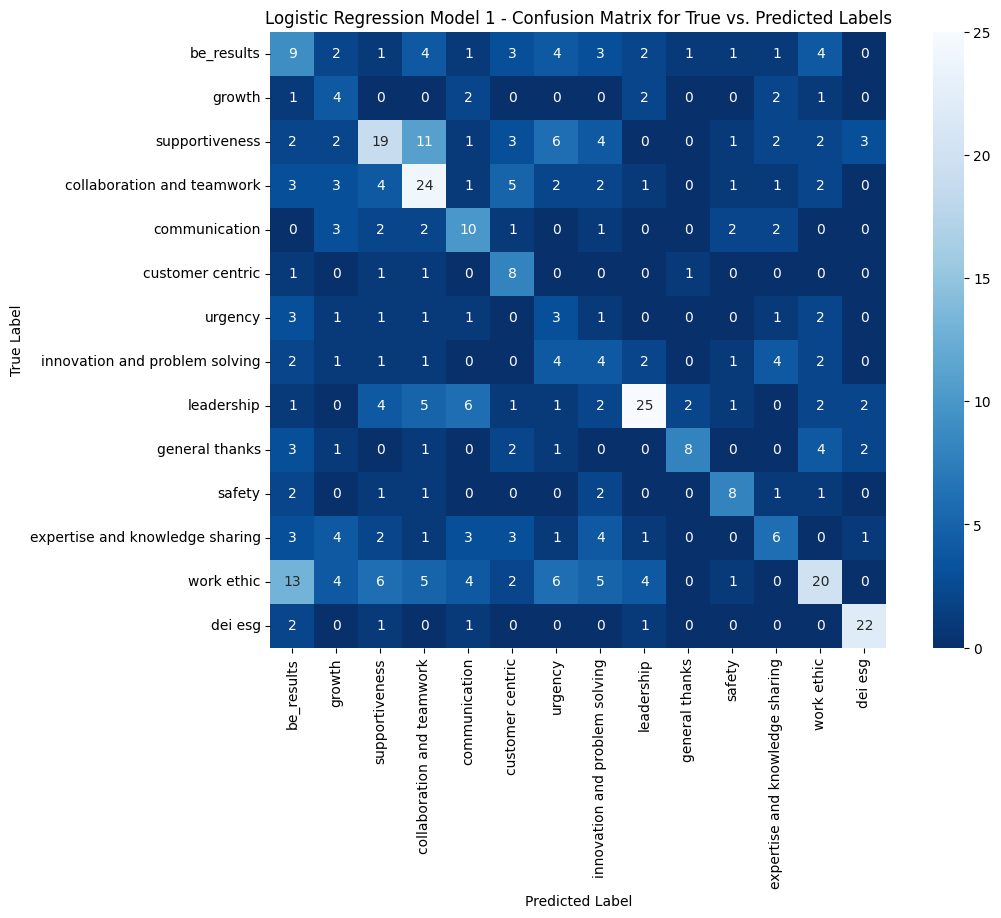

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_1, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("Logistic Regression Model 1 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

#### XGBoost

In [ ]:
%%time
## train model_1 with xgboost
classifier_1_xgb, train_score_1_xgb, test_score_1_xgb, y_test_pred_1_xgb, y_test_proba_1_xgb, cm_1_xgb = train_xgb(train_texts.to_numpy(), train_labels, val_texts.to_numpy(), val_labels, model1)


In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels  # Assuming val_labels here is the one with 513 samples

## print results
print('Train score: ', train_score_1_xgb)
print('Test score: ', test_score_1_xgb)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_1:", y_test_pred_1_xgb.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_1_xgb, target_names=labels.keys()))

Train score:  0.994874715261959
Test score:  0.36818181818181817
Shape of test_labels: (440,)
Shape of y_test_pred_1: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.29      0.36      0.32        36
                         growth       0.20      0.08      0.12        12
                 supportiveness       0.30      0.52      0.38        56
     collaboration and teamwork       0.39      0.33      0.36        49
                  communication       0.32      0.26      0.29        23
               customer centric       0.50      0.58      0.54        12
                        urgency       0.00      0.00      0.00        14
 innovation and problem solving       0.10      0.05      0.06        22
                     leadership       0.44      0.52      0.47        52
                 general thanks       1.00      0.23      0.37        22
                         safety       0.50      0.25      0.33        1

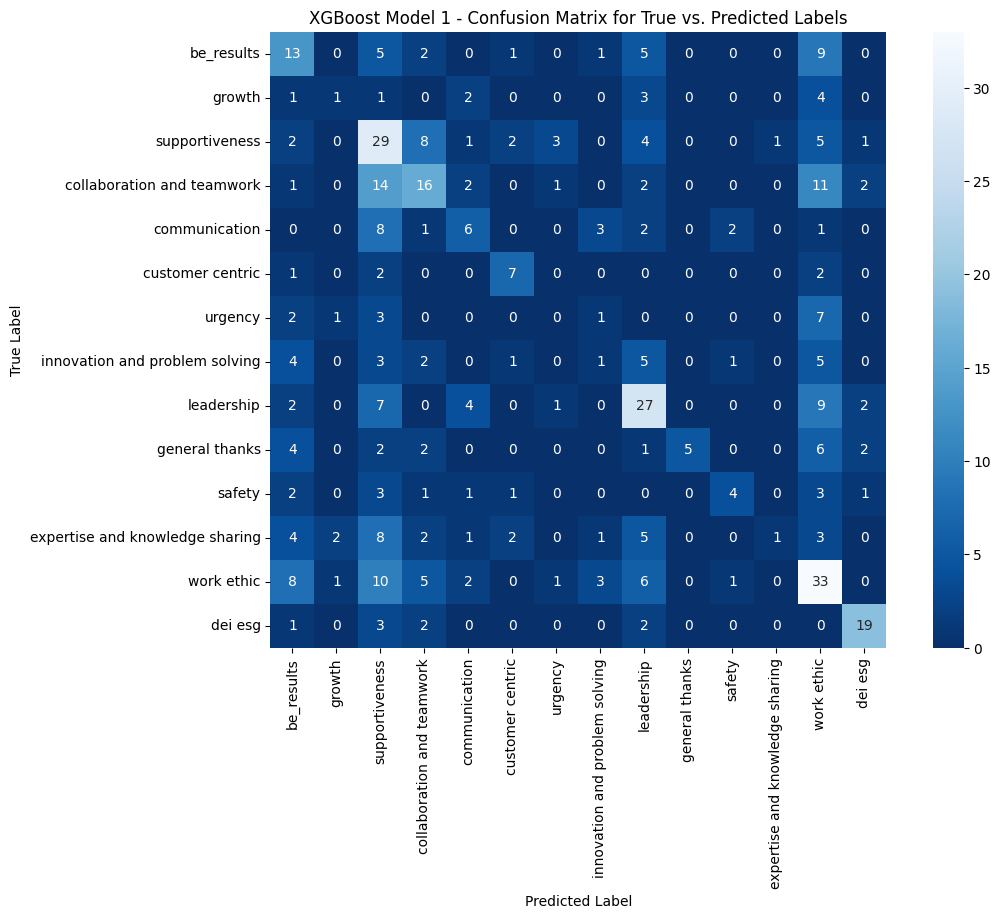

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_1_xgb, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("XGBoost Model 1 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

### Embedding Model 2
* sentence-transformers/paraphrase-mpnet-base-v2
  * Max Sequence Length: 512
  * Dimensions: 768


#### Logistic Regression

In [ ]:
# Train the model
classifier_2, train_score_2, test_score_2, y_test_pred_2, y_test_proba_2, cm_2 = train(train_texts.to_numpy(), train_labels, val_texts.to_numpy(), val_labels, model2)

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels  # Assuming val_labels here is the one with 513 samples

## print results
print('Train score: ', train_score_2)
print('Test score: ', test_score_2)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_2:", y_test_pred_2.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_2, target_names=labels.keys()))

Train score:  0.7528473804100227
Test score:  0.41363636363636364
Shape of test_labels: (440,)
Shape of y_test_pred_2: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.28      0.22      0.25        36
                         growth       0.37      0.58      0.45        12
                 supportiveness       0.38      0.34      0.36        56
     collaboration and teamwork       0.41      0.33      0.36        49
                  communication       0.33      0.48      0.39        23
               customer centric       0.24      0.67      0.36        12
                        urgency       0.28      0.64      0.39        14
 innovation and problem solving       0.14      0.14      0.14        22
                     leadership       0.60      0.50      0.55        52
                 general thanks       0.52      0.55      0.53        22
                         safety       0.72      0.81      0.76        

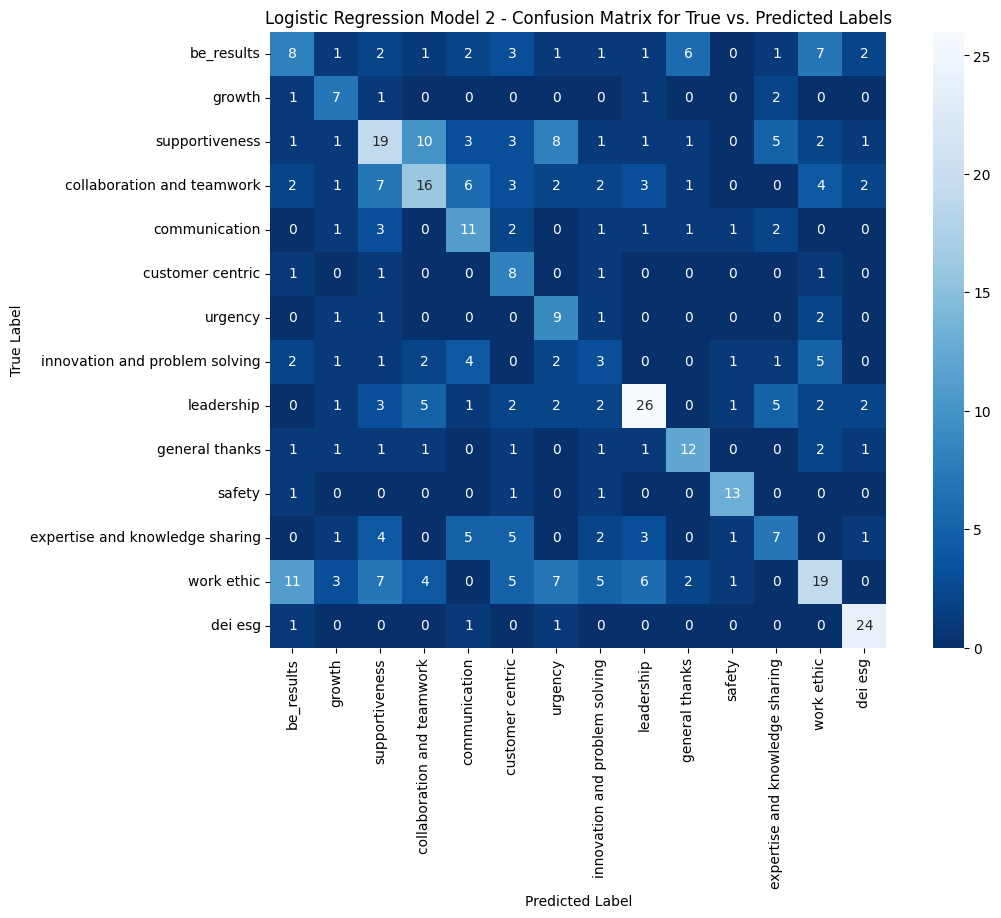

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_2, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("Logistic Regression Model 2 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

#### XGBoost

In [ ]:
%%time
## train model_2 with xgboost
classifier_2_xgb, train_score_2_xgb, test_score_2_xgb, y_test_pred_2_xgb, y_test_proba_2_xgb, cm_2_xgb = train_xgb(train_texts.to_numpy(), train_labels, val_texts.to_numpy(), val_labels, model2)


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 1min 5s, sys: 174 ms, total: 1min 5s
Wall time: 1min 6s


In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels

## print results
print('Train score: ', train_score_2_xgb)
print('Test score: ', test_score_2_xgb)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_2:", y_test_pred_2_xgb.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_2_xgb, target_names=labels.keys()))


Train score:  0.9982915717539863
Test score:  0.35454545454545455
Shape of test_labels: (440,)
Shape of y_test_pred_2: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.21      0.39      0.27        36
                         growth       0.30      0.25      0.27        12
                 supportiveness       0.29      0.57      0.38        56
     collaboration and teamwork       0.28      0.18      0.22        49
                  communication       0.21      0.13      0.16        23
               customer centric       0.27      0.25      0.26        12
                        urgency       0.62      0.36      0.45        14
 innovation and problem solving       0.29      0.09      0.14        22
                     leadership       0.47      0.48      0.48        52
                 general thanks       0.75      0.14      0.23        22
                         safety       0.91      0.62      0.74        

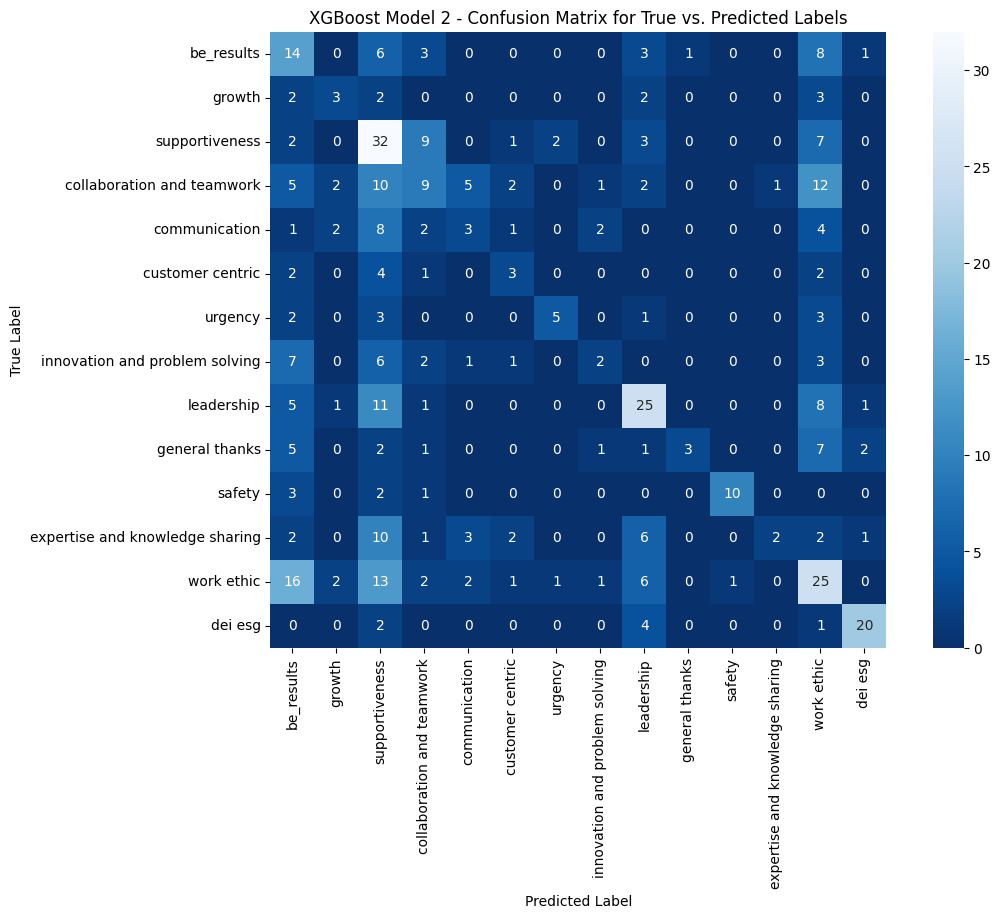

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_2_xgb, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("XGBoost Model 2 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

### Embedding Model 3
* mixedbread-ai/mxbai-embed-large-v1
  * Max Sequence Length: 512
  * Dimensions: 1024


#### Logistic Regression

In [ ]:
# Train the model
classifier_3, train_score_3, test_score_3, y_test_pred_3, y_test_proba_3, cm_3 = train(train_texts.to_numpy(), train_labels, val_texts.to_numpy(), val_labels, model3)

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels  # Assuming val_labels here is the one with 513 samples

## print results
print('Train score: ', train_score_3)
print('Test score: ', test_score_3)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_3:", y_test_pred_3.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_3, target_names=labels.keys()))

Train score:  0.7334851936218679
Test score:  0.33636363636363636
Shape of test_labels: (440,)
Shape of y_test_pred_3: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.26      0.28      0.27        36
                         growth       0.19      0.33      0.24        12
                 supportiveness       0.40      0.34      0.37        56
     collaboration and teamwork       0.35      0.35      0.35        49
                  communication       0.15      0.17      0.16        23
               customer centric       0.25      0.58      0.35        12
                        urgency       0.19      0.43      0.27        14
 innovation and problem solving       0.09      0.14      0.11        22
                     leadership       0.56      0.37      0.44        52
                 general thanks       0.41      0.32      0.36        22
                         safety       0.67      0.88      0.76        

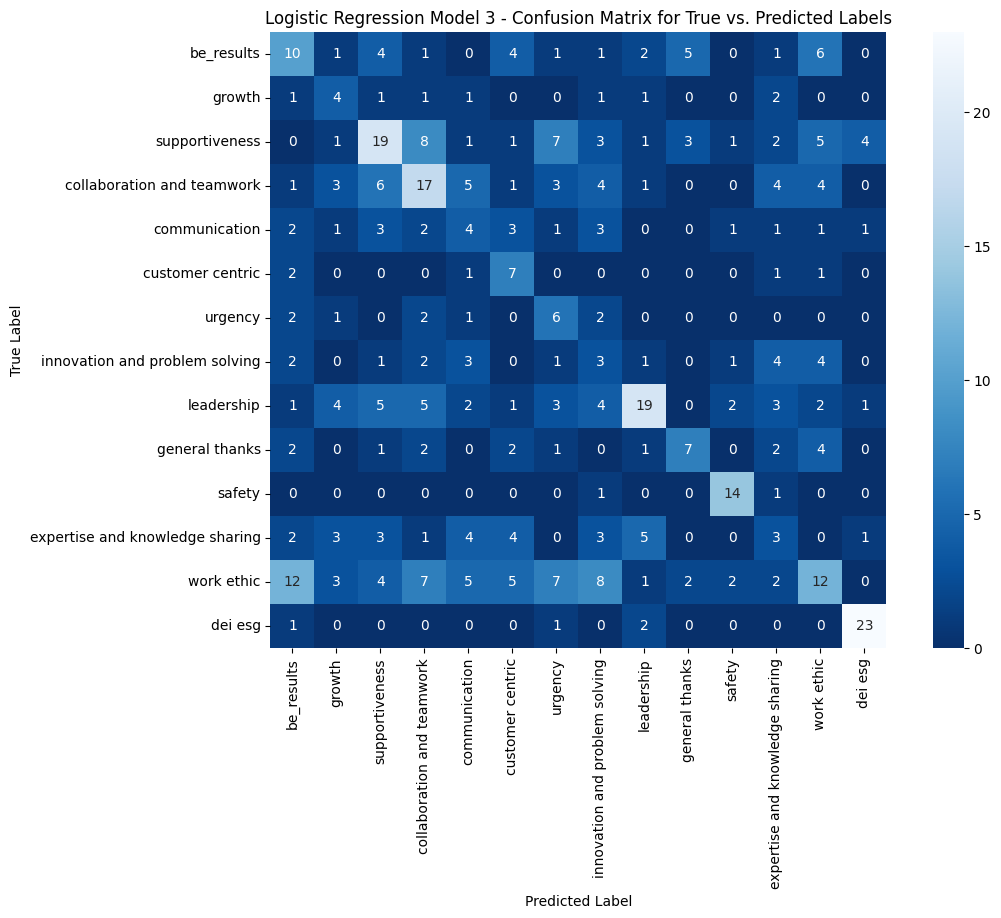

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_3, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("Logistic Regression Model 3 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

#### XGBoost

In [ ]:
%%time
## train model_3 with xgboost
classifier_3_xgb, train_score_3_xgb, test_score_3_xgb, y_test_pred_3_xgb, y_test_proba_3_xgb, cm_3_xgb = train_xgb(train_texts.to_numpy(), train_labels, val_texts.to_numpy(), val_labels, model3)


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 28.8 s, sys: 81 ms, total: 28.9 s
Wall time: 29.5 s


In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels

## print results
print('Train score: ', train_score_3_xgb)
print('Test score: ', test_score_3_xgb)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_3:", y_test_pred_3_xgb.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_3_xgb, target_names=labels.keys()))


Train score:  0.9954441913439636
Test score:  0.33636363636363636
Shape of test_labels: (440,)
Shape of y_test_pred_3: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.24      0.36      0.29        36
                         growth       0.14      0.08      0.11        12
                 supportiveness       0.25      0.52      0.34        56
     collaboration and teamwork       0.28      0.22      0.25        49
                  communication       0.22      0.09      0.12        23
               customer centric       0.36      0.33      0.35        12
                        urgency       0.33      0.14      0.20        14
 innovation and problem solving       0.06      0.05      0.05        22
                     leadership       0.44      0.50      0.47        52
                 general thanks       1.00      0.14      0.24        22
                         safety       0.75      0.56      0.64        

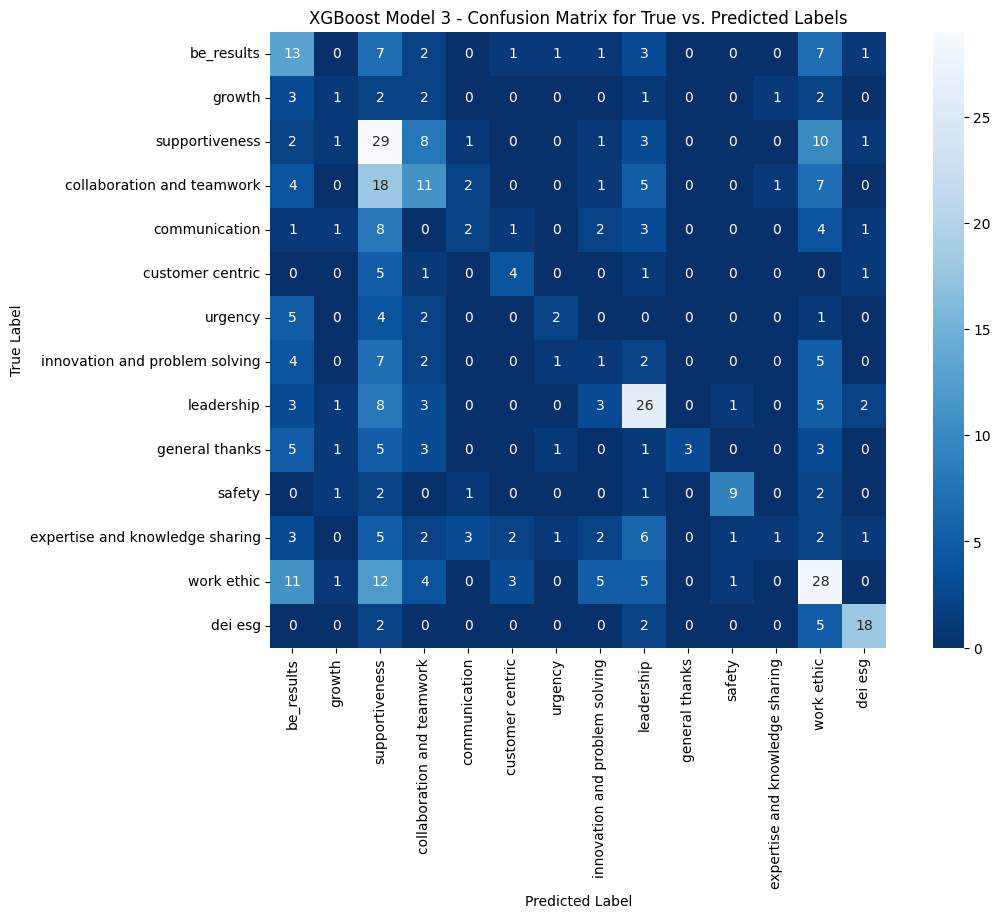

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_3_xgb, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("XGBoost Model 3 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

### Embedding Model 4
* mixedbread-ai/mxbai-embed-xsmall-v1
  * Max Sequence Length: 4096
  * Dimensions: 384

* Note: Based on sentence-transformers/all-MiniLM-L6-v2, this model has only 22.7 million parameters and is trained in float16 for efficiency.

#### Logistic Regression

In [ ]:
# Train the model
classifier_4, train_score_4, test_score_4, y_test_pred_4, y_test_proba_4, cm_4 = train(train_texts.to_numpy(), train_labels, val_texts.to_numpy(), val_labels, model4)

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels

## print results
print('Train score: ', train_score_4)
print('Test score: ', test_score_4)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_4:", y_test_pred_4.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_4, target_names=labels.keys()))

Train score:  0.9817767653758542
Test score:  0.375
Shape of test_labels: (440,)
Shape of y_test_pred_4: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.20      0.22      0.21        36
                         growth       0.36      0.42      0.38        12
                 supportiveness       0.38      0.36      0.37        56
     collaboration and teamwork       0.31      0.35      0.33        49
                  communication       0.38      0.39      0.38        23
               customer centric       0.36      0.67      0.47        12
                        urgency       0.22      0.36      0.27        14
 innovation and problem solving       0.17      0.18      0.17        22
                     leadership       0.50      0.44      0.47        52
                 general thanks       0.30      0.27      0.29        22
                         safety       0.80      0.75      0.77        16
expertise a

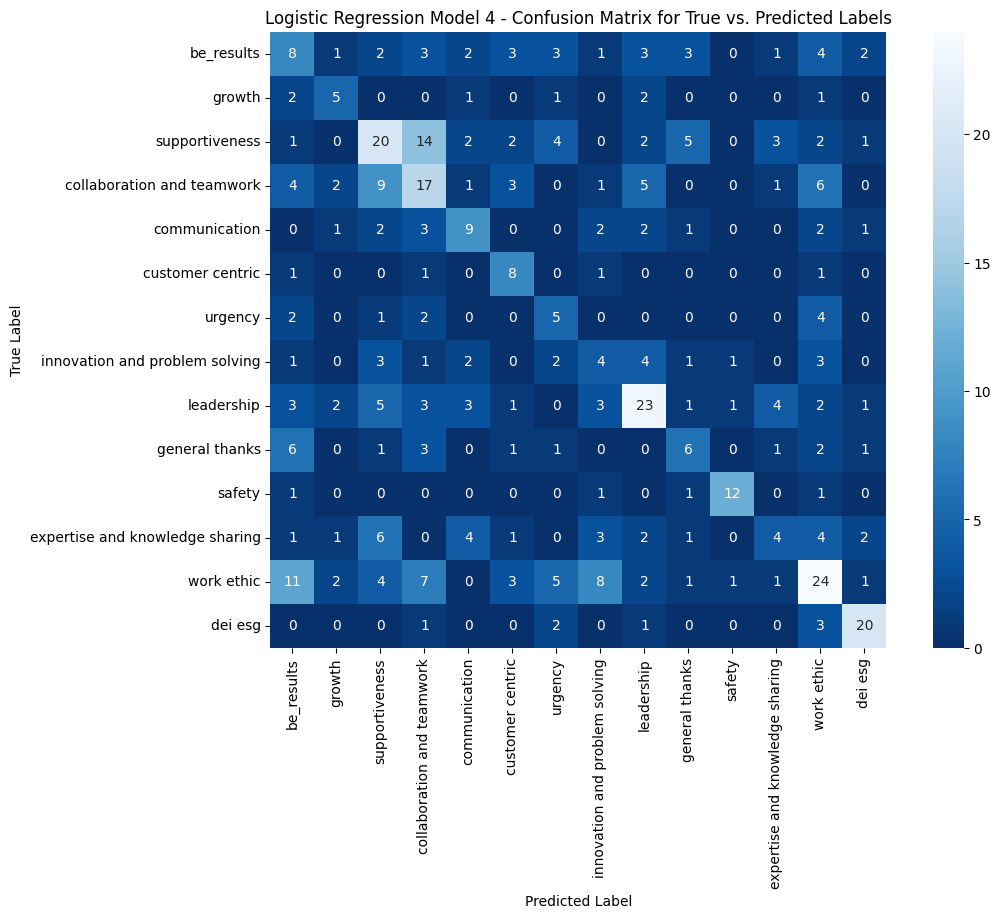

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_4, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("Logistic Regression Model 4 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

#### XGBoost

In [ ]:
%%time
## train model_2 with xgboost
classifier_4_xgb, train_score_4_xgb, test_score_4_xgb, y_test_pred_4_xgb, y_test_proba_4_xgb, cm_4_xgb = train_xgb(train_texts.to_numpy(),train_labels, val_texts.to_numpy(), val_labels , model4)


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 1min 43s, sys: 241 ms, total: 1min 43s
Wall time: 1min 48s


In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels

## print results
print('Train score: ', train_score_4_xgb)
print('Test score: ', test_score_4_xgb)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_4:", y_test_pred_4_xgb.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_4_xgb, target_names=labels.keys()))


Train score:  0.9994305239179955
Test score:  0.3386363636363636
Shape of test_labels: (440,)
Shape of y_test_pred_4: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.18      0.28      0.22        36
                         growth       0.00      0.00      0.00        12
                 supportiveness       0.27      0.46      0.34        56
     collaboration and teamwork       0.27      0.27      0.27        49
                  communication       0.41      0.30      0.35        23
               customer centric       0.54      0.58      0.56        12
                        urgency       0.11      0.07      0.09        14
 innovation and problem solving       0.60      0.14      0.22        22
                     leadership       0.37      0.48      0.42        52
                 general thanks       0.40      0.09      0.15        22
                         safety       0.90      0.56      0.69        1

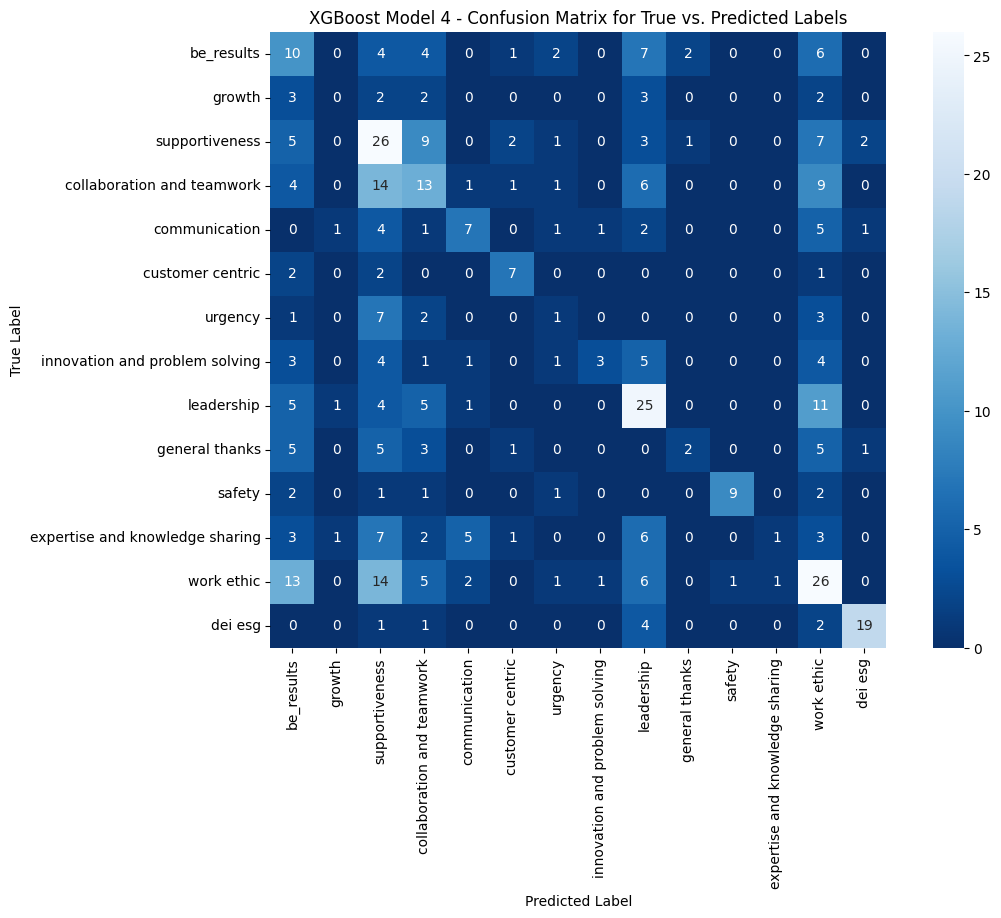

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_4_xgb, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("XGBoost Model 4 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

### Embedding Model 5
* `jinaai/jina-embeddings-v2-small-en`
  * Max Sequence Length: 8192
  * Dimensions: 512

#### Logistic Regression

In [ ]:
# Train the model
classifier_5, train_score_5, test_score_5, y_test_pred_5, y_test_proba_5, cm_5 = train(train_texts.to_numpy(), train_labels, val_texts.to_numpy(), val_labels, model5)

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels

## print results
print('Train score: ', train_score_5)
print('Test score: ', test_score_5)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_5:", y_test_pred_5.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_5, target_names=labels.keys()))

Train score:  0.7613895216400911
Test score:  0.35454545454545455
Shape of test_labels: (440,)
Shape of y_test_pred_5: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.10      0.11      0.11        36
                         growth       0.30      0.58      0.40        12
                 supportiveness       0.36      0.29      0.32        56
     collaboration and teamwork       0.37      0.31      0.33        49
                  communication       0.27      0.39      0.32        23
               customer centric       0.28      0.58      0.38        12
                        urgency       0.25      0.50      0.33        14
 innovation and problem solving       0.22      0.27      0.24        22
                     leadership       0.45      0.37      0.40        52
                 general thanks       0.38      0.36      0.37        22
                         safety       0.56      0.56      0.56        

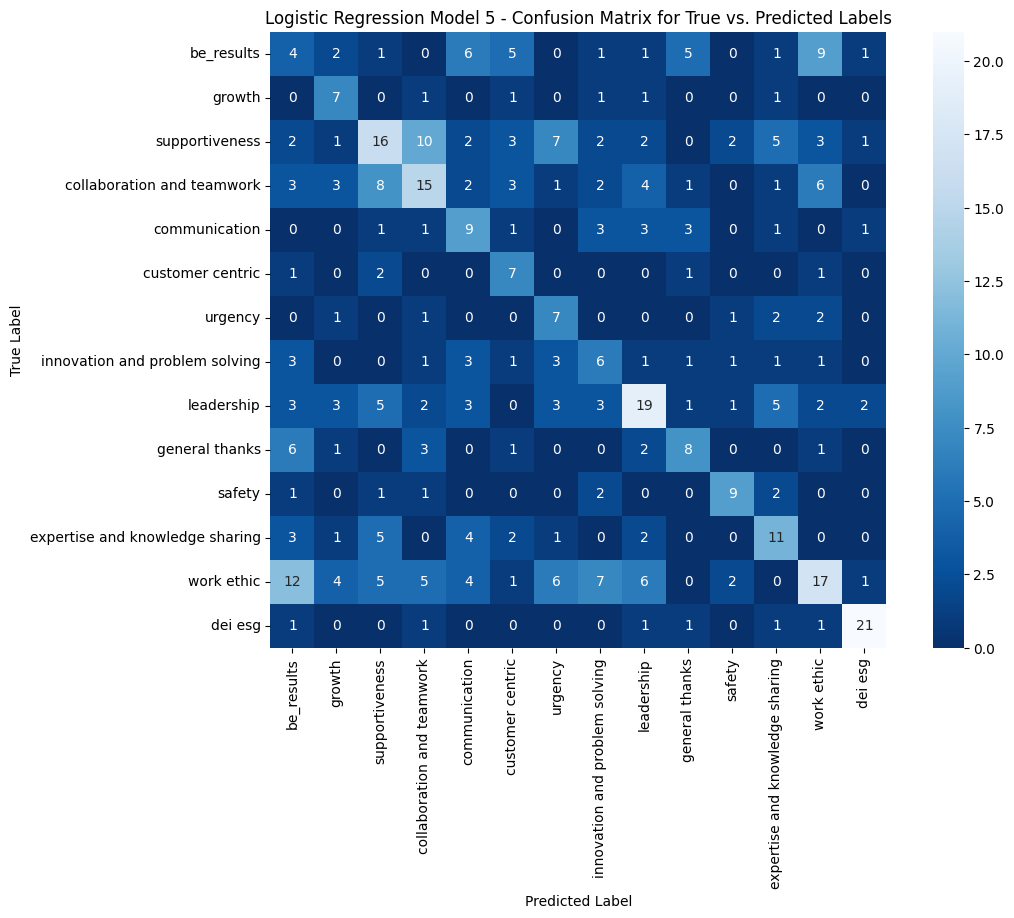

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_5, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("Logistic Regression Model 5 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

#### XGBoost

In [ ]:
%%time
## train model_5 with xgboost
classifier_5_xgb, train_score_5_xgb, test_score_5_xgb, y_test_pred_5_xgb, y_test_proba_5_xgb, cm_5_xgb = train_xgb(train_texts.to_numpy(),train_labels, val_texts.to_numpy(), val_labels, model5)


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

CPU times: user 38.7 s, sys: 93 ms, total: 38.8 s
Wall time: 38.8 s


In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels

## print results
print('Train score: ', train_score_5_xgb)
print('Test score: ', test_score_5_xgb)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_5:", y_test_pred_5_xgb.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_5_xgb, target_names=labels.keys()))


Train score:  0.9971526195899773
Test score:  0.3431818181818182
Shape of test_labels: (440,)
Shape of y_test_pred_5: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.21      0.28      0.24        36
                         growth       0.25      0.17      0.20        12
                 supportiveness       0.37      0.61      0.46        56
     collaboration and teamwork       0.27      0.27      0.27        49
                  communication       0.32      0.26      0.29        23
               customer centric       0.57      0.33      0.42        12
                        urgency       0.33      0.14      0.20        14
 innovation and problem solving       0.21      0.18      0.20        22
                     leadership       0.29      0.37      0.32        52
                 general thanks       0.56      0.23      0.32        22
                         safety       0.83      0.31      0.45        1

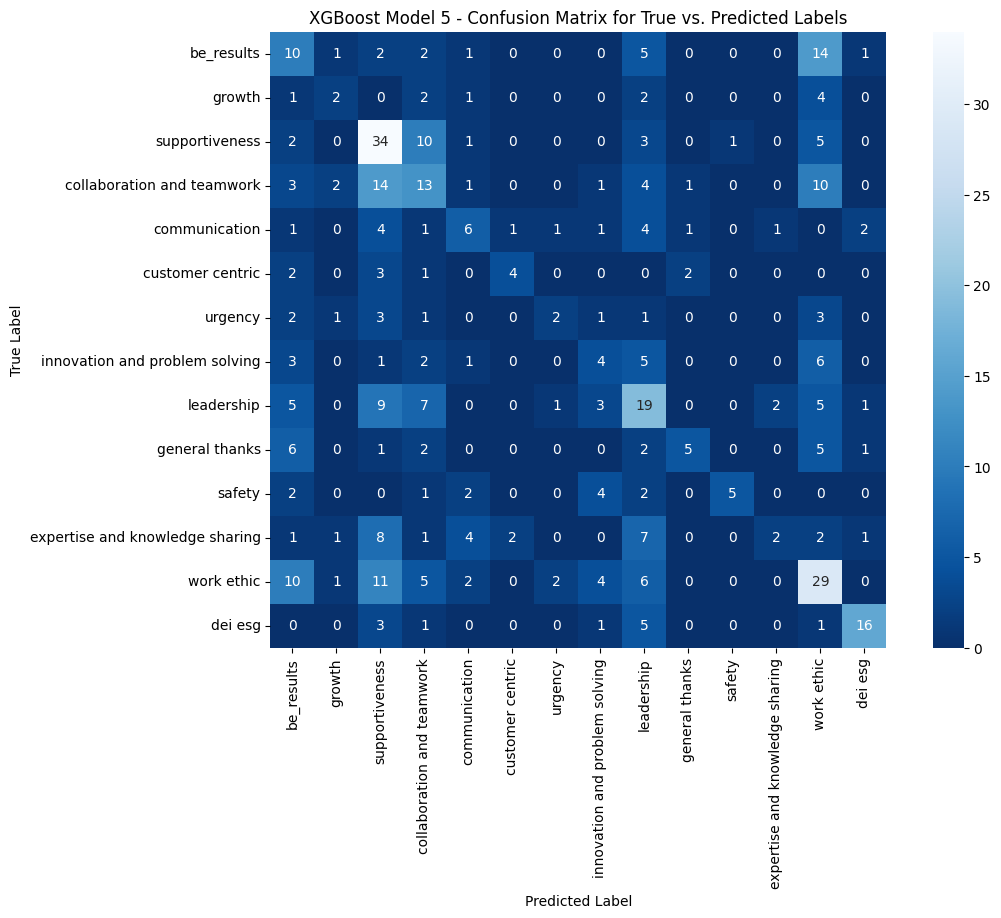

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_5_xgb, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("XGBoost Model 5 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

### Embedding Model 7
* Skipped "6" in case we use NVIDIA model in future.
* This will be interesting as these are the SPLADE sparse embeddings. The reasoning for trying these is that these are somewhat similar to TF-IDF but more robust. TF-IDF was the original algorithm used for the "best LR" model.
* Details:
  * `prithivida/Splade_PP_en_v2`
  * Max Sequence Length: 512
  * Dimensions: 768

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import numpy as np
## updated function for creating splade embeddings
def splade_emb(texts):
    """
    Generates embeddings using the Splade model.

    Args:
        texts: A list of input texts to embed.

    Returns:
        A NumPy array containing the embeddings.
    """
    # Initialize tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained("prithivida/Splade_PP_en_v2")
    model = AutoModelForMaskedLM.from_pretrained("prithivida/Splade_PP_en_v2")

    # Tokenize texts and create embeddings
    embeddings = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt")
        outputs = model(**inputs, output_hidden_states=True)
        embedding = outputs.hidden_states[-1][:, 0, :].detach().numpy()  # Last hidden state, CLS token
        embeddings.append(embedding)

    # Convert the list of embeddings to a NumPy array
    embeddings = np.vstack(embeddings)

    return embeddings

For this model we need to augment the train function to use the "splade_emb" function for the SPLADE model.
  * Logistic Regression Function

In [ ]:
## new train function for using "splade_emb" function
def train(train_texts, train_labels, val_texts, val_labels, embedding_function):
    """
    Trains a classification model using the provided embedding function.

    Args:
        train_texts: Training text data.
        train_labels: Training labels.
        val_texts: Validation text data.
        val_labels: Validation labels.
        embedding_function: The function to use for generating embeddings.

    Returns:
        A tuple containing the trained classifier, training score, test score,
        test predictions, test probabilities, and confusion matrix.
    """

    ## create embeddings using the provided embedding_function
    train_embeddings = embedding_function(train_texts)
    val_embeddings = embedding_function(val_texts)

    ## train model --- using original default LR settings
    classifier = LogisticRegression(C=1, penalty='l2', solver='liblinear', random_state=42, class_weight='balanced')
    classifier.fit(train_embeddings, train_labels)

    ## evaluate model
    train_score = accuracy_score(train_labels, classifier.predict(train_embeddings))
    test_score = accuracy_score(val_labels, classifier.predict(val_embeddings))
    y_test_pred = classifier.predict(val_embeddings)
    y_test_proba = classifier.predict_proba(val_embeddings)
    cm = confusion_matrix(val_labels, y_test_pred)

    return classifier, train_score, test_score, y_test_pred, y_test_proba, cm

#### Logistic Regression

In [ ]:
# Train the model using custom "splade_emb" function
classifier_7, train_score_7, test_score_7, y_test_pred_7, y_test_proba_7, cm_7 = train(
    train_texts, train_labels, val_texts, val_labels, splade_emb
)

In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels

## print results
print('Train score: ', train_score_7)
print('Test score: ', test_score_7)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_7:", y_test_pred_7.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_7, target_names=labels.keys()))

Train score:  0.7659453302961275
Test score:  0.25227272727272726
Shape of test_labels: (440,)
Shape of y_test_pred_7: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.15      0.17      0.16        36
                         growth       0.07      0.17      0.10        12
                 supportiveness       0.28      0.25      0.26        56
     collaboration and teamwork       0.27      0.22      0.24        49
                  communication       0.19      0.26      0.22        23
               customer centric       0.30      0.50      0.38        12
                        urgency       0.14      0.36      0.20        14
 innovation and problem solving       0.13      0.18      0.15        22
                     leadership       0.29      0.29      0.29        52
                 general thanks       0.33      0.27      0.30        22
                         safety       0.44      0.44      0.44        

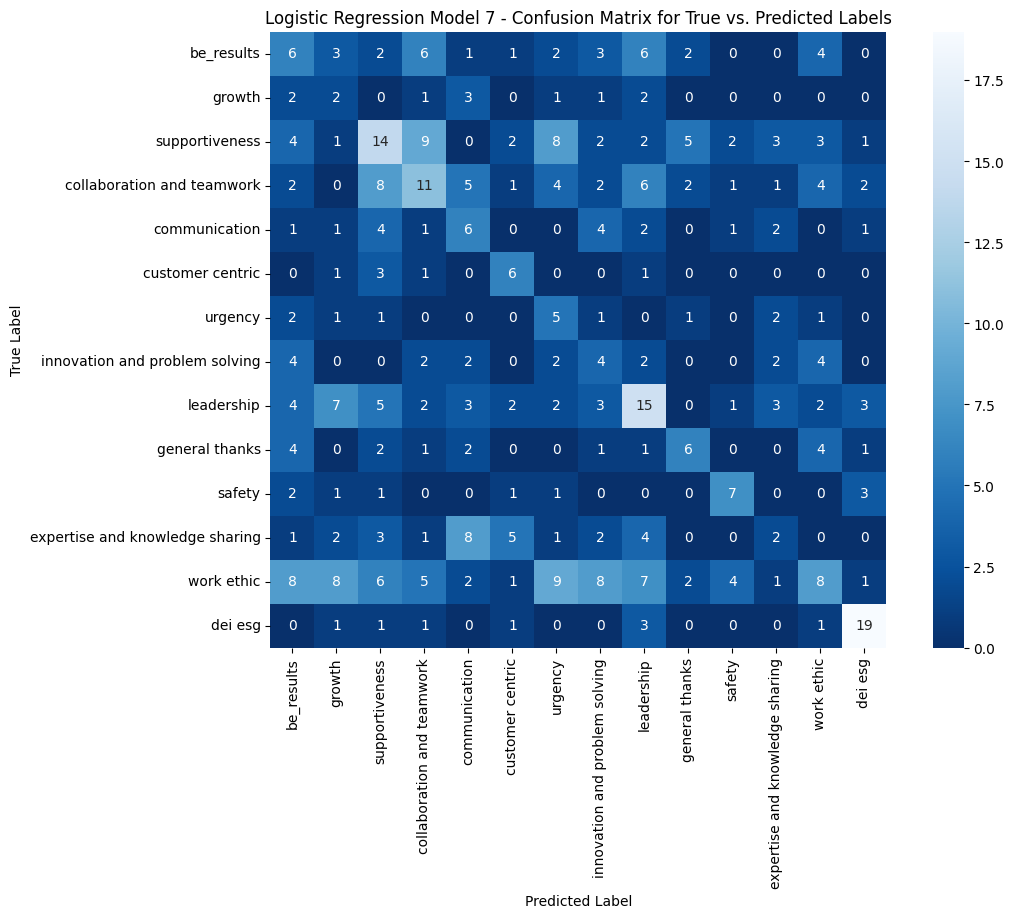

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_7, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("Logistic Regression Model 7 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

For this model we need to augment the train function to use the "splade_emb" function for the SPLADE model.
  * XGBoost Function

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix

## new XGB function
def train_xgb(train_texts, train_labels, val_texts, val_labels, embedding_function):
    """
    Trains an XGBoost classification model using SentenceTransformer embeddings.

    Args:
        train_texts: List of training texts.
        train_labels: List of training labels.
        val_texts: List of validation texts.
        val_labels: List of validation labels.
        embedding_function: Function for generating embeddings.

    Returns:
        A tuple containing the trained classifier, training score, test score,
        test predictions, test probabilities, and confusion matrix.
    """

    ## 1. Create embeddings
    train_embeddings = embedding_function(train_texts)
    val_embeddings = embedding_function(val_texts)

    ## 2. Machine Learning Classification Model Setup -- XGBoost
    # Define XGBoost classifier with parameters
    classifier = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=len(set(train_labels)),  # Use 'label' instead of 'y_true'
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    )

    # Train the XGBoost classifier using train_embeddings
    classifier.fit(train_embeddings, train_labels)

    ## 3. Obtain accuracy score for train and validation sets
    train_score = accuracy_score(train_labels, classifier.predict(train_embeddings))
    val_score = accuracy_score(val_labels, classifier.predict(val_embeddings))

    ## 4. Predict on validation set
    y_val_pred = classifier.predict(val_embeddings)
    y_val_proba = classifier.predict_proba(val_embeddings)

    ## 5. Return confusion matrix calculated on validation set
    cm = confusion_matrix(val_labels, y_val_pred)

    return classifier, train_score, val_score, y_val_pred, y_val_proba, cm

#### XGBoost

In [ ]:
# Train the xgboost model using custom "splade_emb" function
classifier_7_xgb, train_score_7, test_score_7, y_test_pred_7, y_test_proba_7, cm_7 = train_xgb(
    train_texts, train_labels, val_texts, val_labels, splade_emb
)

In [ ]:
# Rename val_labels (test set labels) to test_labels for clarity:
test_labels = val_labels

## print results
print('Train score: ', train_score_7)
print('Test score: ', test_score_7)

# Check the shapes
print("Shape of test_labels:", test_labels.shape)
print("Shape of y_test_pred_7:", y_test_pred_7.shape)

# Use the renamed variable for the classification report:
print(classification_report(test_labels, y_test_pred_7, target_names=labels.keys()))

Train score:  0.7659453302961275
Test score:  0.25227272727272726
Shape of test_labels: (440,)
Shape of y_test_pred_7: (440,)
                                 precision    recall  f1-score   support

                     be_results       0.15      0.17      0.16        36
                         growth       0.07      0.17      0.10        12
                 supportiveness       0.28      0.25      0.26        56
     collaboration and teamwork       0.27      0.22      0.24        49
                  communication       0.19      0.26      0.22        23
               customer centric       0.30      0.50      0.38        12
                        urgency       0.14      0.36      0.20        14
 innovation and problem solving       0.13      0.18      0.15        22
                     leadership       0.29      0.29      0.29        52
                 general thanks       0.33      0.27      0.30        22
                         safety       0.44      0.44      0.44        

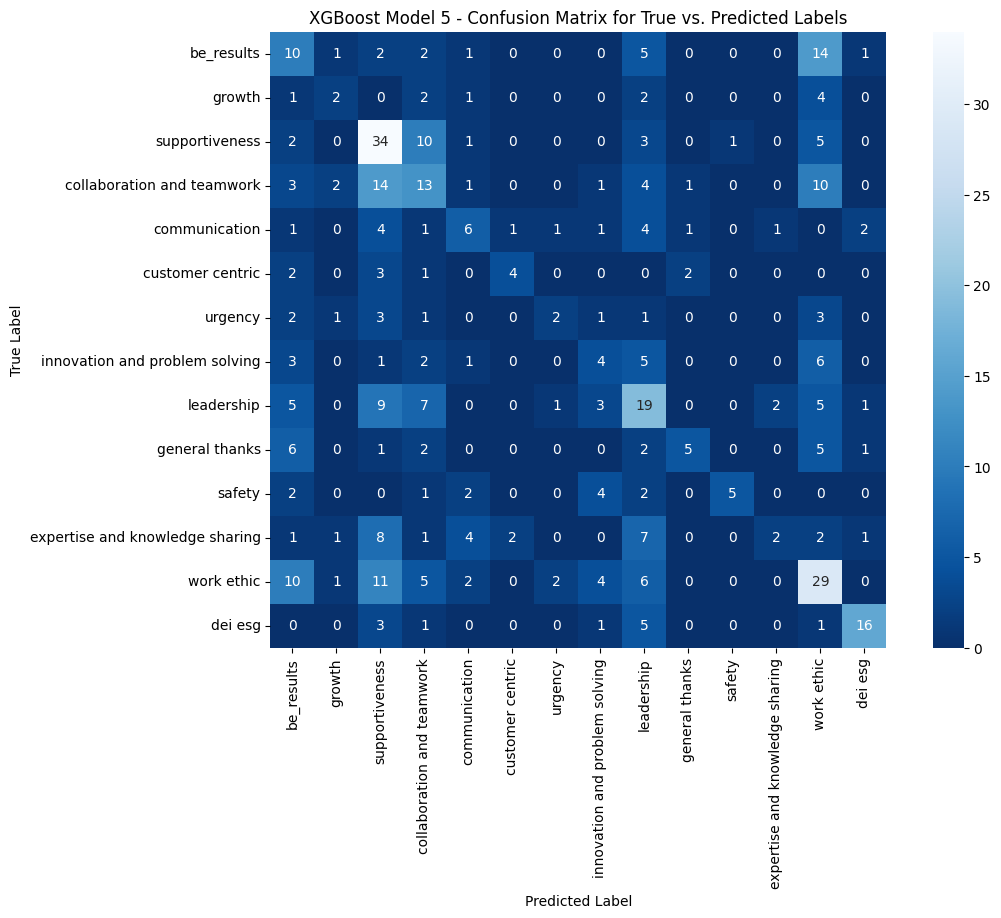

In [ ]:
## plot confusion matrix
fig = plt.figure(figsize=(12, 8))
## seaborn heatmap
sns.heatmap(cm_7_xgb, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='horizontal')
plt.xticks([i+0.5 for i in list(labels.values())], list(labels.keys()), rotation ='vertical')
plt.title("XGBoost Model 5 - Confusion Matrix for True vs. Predicted Labels")
plt.show();

# Model 2 Experiment -- Hyperparameter optimization with embeddings
* For this next set of experiments I will try hyperparameter optimization using grid search and k-folds cross validation with embeddings and see which model(s) end up being the best.

## Logistic Regression Bayesian Optimization Function with optuna to Train final model with best parameters

This `train_log_optuna` function takes the following inputs:

- `texts`: List of input texts
- `labels`: List of corresponding labels
- `embedding_model`: SentenceTransformer model
- `n_trials` (optional): Number of trials for hyperparameter optimization (default: 100)
- `n_folds` (optional): Number of folds for cross-validation (default: 5)

The function returns:

- `best_model`: The best logistic regression model with optimized hyperparameters
- `best_params`: The best hyperparameters found by Optuna
- `best_score`: The best cross-validation accuracy score achieved

In [ ]:
# install optuna
!pip install optuna

### Train and optimize Logistic Regression Model -- WITHOUT Class Weights optimization for imbalanced target class

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

## logistic regression optuna function
def train_log_optuna(texts, labels, embedding_model, n_trials=60, n_folds=5):
    """
    Trains a logistic regression model using SentenceTransformer embeddings, with hyperparameter optimization
    using Optuna and stratified k-fold cross-validation.

    Args:
        texts: List of input texts.
        labels: List of corresponding labels.
        embedding_model: SentenceTransformer model or other model of choice.
        n_trials: Number of trials for hyperparameter optimization (default: 100).
        n_folds: Number of folds for cross-validation (default: 5).

    Returns:
        Best logistic regression model, best hyperparameters, and best cross-validation score.
    """

    # Create embeddings
    embeddings = embedding_model.encode(texts, show_progress_bar=True)

    ## objective function
    def objective(trial):
        # Define the search space for hyperparameters
        C = trial.suggest_float('C', 1e-5, 1e5, log=True)
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])

        # Initialize stratified k-fold cross-validation
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_scores = []

        # Perform stratified k-fold cross-validation
        for train_idx, val_idx in skf.split(embeddings, labels):
            X_train, X_val = embeddings[train_idx], embeddings[val_idx]
            y_train, y_val = np.array(labels)[train_idx], np.array(labels)[val_idx]

            # Create and train logistic regression model
            model = LogisticRegression(C=C, penalty=penalty, solver=solver, random_state=42)
            model.fit(X_train, y_train)

            # Evaluate model on validation set using accuracy
            y_pred = model.predict(X_val)
            cv_score = accuracy_score(y_val, y_pred)
            cv_scores.append(cv_score)

        # Return the mean cross-validation score as the objective to minimize
        return -np.mean(cv_scores)

    # Create Optuna study
    study = optuna.create_study(direction='minimize')

    # Perform hyperparameter optimization
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Train the best model on the entire dataset
    best_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'],
                                    random_state=42)
    best_model.fit(embeddings, labels)

    return best_model, best_params, -study.best_value

If using normal train_data and test_data run this code block

In [ ]:
%%time
# Split the train_data into train and validation sets
## note: if using normal unsampled data use this for X and y: train_data['text'], train_data['y_true']

train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['text'], train_data['y_true'], test_size=0.2, random_state=42)

# Reset index of train_texts and val_texts to ensure they're continuous sequences
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True) # Reset index for val_texts as well

# 1. Train the logistic regression model with hyperparameter optimization
best_model, best_params, best_cv_score = train_log_optuna(train_texts,
                                                          train_labels,
                                                          embedding_model=model1) ##change embedding model

# 2. Print the best hyperparameters and best cross-validation score
print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation accuracy score: {best_cv_score:.4f}")

### Perform SMOTE upsampling and then train model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sentence_transformers import SentenceTransformer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming X_original contains the original text data and y_original contains the original labels
# 1. Perform SMOTE upsampling on the original text data
X_original = train_data['text']
y_original = train_data['y_true']

# 2. Create TF-IDF vectors from the original text data
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_original)

## run smote upsampling on the TF-IDF vectors, not the raw text
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_tfidf, y_original)



Batches:   0%|          | 0/110 [00:00<?, ?it/s]

[I 2024-11-07 15:38:26,777] A new study created in memory with name: no-name-8c0a48aa-8fb9-4470-9148-8674b65e35c9
[I 2024-11-07 15:38:32,749] Trial 0 finished with value: -0.2724679029957204 and parameters: {'C': 0.00045709897346310946, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: -0.2724679029957204.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not

Best hyperparameters: {'C': 137.8271048767696, 'penalty': 'l1', 'solver': 'saga'}
Best cross-validation accuracy score: 0.4736


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train and test using function

In [ ]:
# 3. Split the upsampled data into train and validation sets
# Use X_smote (TF-IDF vectors) instead of X_smote_text for training
train_texts, val_texts, train_labels, val_labels = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# 4. Load the embedding model
emb_model = model2 # Change for each embedding model

# 5. Convert the TF-IDF vectors to text embeddings before training the model
# No need to inverse_transform here as train_texts and val_texts are already TF-IDF vectors
#train_embeddings = model.encode(vectorizer.inverse_transform(train_texts), show_progress_bar=True) # These lines are not needed as they are already encoded inside the train_log_optuna function
#val_embeddings = model.encode(vectorizer.inverse_transform(val_texts), show_progress_bar=True)

# 6. Train the logistic regression model with hyperparameter optimization
# Use inverse_transform within train_log_optuna
best_model, best_params, best_cv_score = train_log_optuna(vectorizer.inverse_transform(train_texts), train_labels, embedding_model=emb_model) # Pass the raw texts to train_log_optuna

# 7. Print the best hyperparameters and best cross-validation score
print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation accuracy score: {best_cv_score:.4f}")

Batches:   0%|          | 0/110 [00:00<?, ?it/s]

[I 2024-11-07 17:54:06,974] A new study created in memory with name: no-name-3044fd49-6791-46ee-9337-50e4d94ab070


In [ ]:
# Get the embeddings for the train and test sets
embedding_model = model2
# Convert sparse matrices to dense arrays before encoding
train_texts_dense = train_texts.toarray()  # Convert train_texts to dense array
val_texts_dense = val_texts.toarray()    # Convert val_texts to dense array

# The input to encode should be the original text data,
# which can be retrieved by inverse_transforming the TF-IDF vectors
train_embeddings = embedding_model.encode(vectorizer.inverse_transform(train_texts_dense), show_progress_bar=True)
test_embeddings = embedding_model.encode(vectorizer.inverse_transform(val_texts_dense), show_progress_bar=True)

# Train the best model on the train set
best_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'],
                                random_state=42)
best_model.fit(train_embeddings, train_labels)

# Get the predictions on the train and test sets
train_preds = best_model.predict(train_embeddings)
test_preds = best_model.predict(test_embeddings)

# Calculate the accuracy scores on the train and test sets
train_accuracy = accuracy_score(train_labels, train_preds)
test_accuracy = accuracy_score(val_labels, test_preds)

# Print the results
print(f"Train accuracy score: {train_accuracy:.4f}")
print(f"Test accuracy score: {test_accuracy:.4f}")

# Check the shapes
print("Shape of train_labels:", len(train_labels))
print("Shape of train_preds:", len(train_preds))
print("Shape of test_labels:", len(val_labels))
print("Shape of test_preds:", len(test_preds))

# Print the classification report on the test set
print("Classification report on test set:")
target_names = [str(label) for label in set(train_labels)]
print(classification_report(val_labels, test_preds, target_names=target_names))
print(classification_report(val_labels, test_preds, target_names=list(set(labels))))

Batches:   0%|          | 0/110 [00:00<?, ?it/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Train accuracy score: 0.5643
Test accuracy score: 0.3592
Shape of train_labels: 3505
Shape of train_preds: 3505
Shape of test_labels: 877
Shape of test_preds: 877
Classification report on test set:
              precision    recall  f1-score   support

           0       0.38      0.23      0.29        69
           1       0.52      0.42      0.46        72
           2       0.25      0.18      0.21        71
           3       0.18      0.14      0.16        59
           4       0.44      0.44      0.44        59
           5       0.51      0.36      0.42        75
           6       0.41      0.58      0.48        45
           7       0.47      0.41      0.44        66
           8       0.11      0.17      0.13        53
           9       0.38      0.53      0.44        58
          10       0.38      0.46      0.42        57
          11       0.36      0.48      0.41        62
          12       0.23      0.17      0.20        69
          13       0.45      0.55      0.49  

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


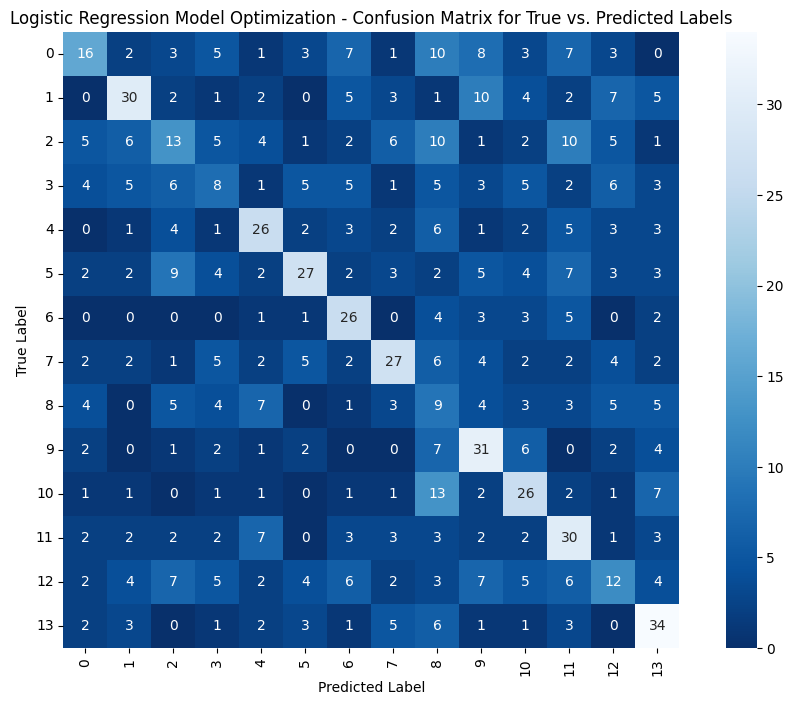

In [ ]:
# Create a label mapping dictionary
unique_labels = sorted(set(val_labels))
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Compute the confusion matrix
cm_log_reg = confusion_matrix(val_labels, test_preds)

# Plot the confusion matrix
fig = plt.figure(figsize=(12, 8))
sns.heatmap(cm_log_reg, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='horizontal')
plt.xticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='vertical')
plt.title("Logistic Regression Model Optimization - Confusion Matrix for True vs. Predicted Labels")
plt.show()

### Train and optimize Logistic Regression Model -- with Class Weights optimization for imbalanced target class

In [ ]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import class_weight
import numpy as np

## logistic regression optuna function
def train_log_optuna(texts, labels, embedding_model, n_trials=100, n_folds=5):
    """
    Trains a logistic regression model using SentenceTransformer embeddings, with hyperparameter optimization
    using Optuna and stratified k-fold cross-validation.

    Args:
        texts: List of input texts.
        labels: List of corresponding labels.
        embedding_model: SentenceTransformer model or other model of choice.
        n_trials: Number of trials for hyperparameter optimization (default: 100).
        n_folds: Number of folds for cross-validation (default: 5).

    Returns:
        Best logistic regression model, best hyperparameters, and best cross-validation score.
    """

    # Create embeddings
    embeddings = embedding_model.encode(texts, show_progress_bar=True)

    ## objective function --- includes optimization for class weights
    def objective(trial):
        # Define the search space for hyperparameters
        C = trial.suggest_float('C', 1e-5, 1e5, log=True)
        penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
        solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
        class_weight_mode = trial.suggest_categorical('class_weight_mode', ['balanced', 'balanced_subsample', None])

        # Initialize stratified k-fold cross-validation
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_scores = []

        # Perform stratified k-fold cross-validation
        for train_idx, val_idx in skf.split(embeddings, labels):
            X_train, X_val = embeddings[train_idx], embeddings[val_idx]
            y_train, y_val = np.array(labels)[train_idx], np.array(labels)[val_idx]

            # Update how class_weights are computed
            if class_weight_mode == 'balanced':
              class_weights = 'balanced'
            elif class_weight_mode == 'balanced_subsample':
              # Call compute_class_weight with updated arguments
              class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
              class_weights = dict(enumerate(class_weights))
            else:
              class_weights = None

            # Create and train logistic regression model
            model = LogisticRegression(C=C, penalty=penalty, solver=solver, class_weight=class_weights, random_state=42)
            model.fit(X_train, y_train)

            # Evaluate model on validation set using accuracy
            y_pred = model.predict(X_val)
            cv_score = accuracy_score(y_val, y_pred)
            cv_scores.append(cv_score)

        # Return the mean cross-validation score as the objective to minimize
        return -np.mean(cv_scores)

    # Create Optuna study
    study = optuna.create_study(direction='minimize')

    # Perform hyperparameter optimization
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Train the best model on the entire dataset
    if best_params['class_weight_mode'] == 'balanced':
        best_class_weight = 'balanced'
    elif best_params['class_weight_mode'] == 'balanced_subsample':
        best_class_weight = class_weight.compute_class_weight('balanced_subsample', np.unique(labels), labels)
        best_class_weight = dict(enumerate(best_class_weight))
    else:
        best_class_weight = None

    best_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'],
                                    class_weight=best_class_weight, random_state=42)
    best_model.fit(embeddings, labels)

    return best_model, best_params, -study.best_value

In [ ]:
%%time
# Split the train_data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['text'], train_data['y_true'], test_size=0.2, random_state=42)

# Reset index of train_texts and val_texts to ensure they're continuous sequences
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True) # Reset index for val_texts as well

# 1. Train the logistic regression model with hyperparameter optimization
best_model, best_params, best_cv_score = train_log_optuna(train_texts,
                                                          train_labels,
                                                          embedding_model=model5) ##change embedding model

# 2. Print the best hyperparameters and best cross-validation score
print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation accuracy score: {best_cv_score:.4f}")

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

[I 2024-11-06 20:41:59,483] A new study created in memory with name: no-name-f680108b-7e9d-4b92-b61c-aeb6c9e66c9f
[I 2024-11-06 20:42:13,545] Trial 0 finished with value: -0.3621843434343434 and parameters: {'C': 6.073588084519287, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight_mode': 'balanced'}. Best is trial 0 with value: -0.3621843434343434.
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached w

Best hyperparameters: {'C': 0.06750240104393827, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight_mode': 'balanced'}
Best cross-validation accuracy score: 0.4260
CPU times: user 16min 22s, sys: 47.7 s, total: 17min 10s
Wall time: 16min 35s


Get Results on test set

In [ ]:
# Get the embeddings for the train and test sets
embedding_model = model1
train_embeddings = embedding_model.encode(train_texts, show_progress_bar=True)
test_embeddings = embedding_model.encode(val_texts, show_progress_bar=True)

# Train the best model on the train set
if best_params['class_weight_mode'] == 'balanced':
    best_class_weight = 'balanced'
elif best_params['class_weight_mode'] == 'balanced_subsample':
    best_class_weight = class_weight.compute_class_weight('balanced_subsample', np.unique(train_labels), train_labels)
    best_class_weight = dict(enumerate(best_class_weight))
else:
    best_class_weight = None

best_model = LogisticRegression(C=best_params['C'], penalty=best_params['penalty'], solver=best_params['solver'],
                                class_weight=best_class_weight, random_state=42)
best_model.fit(train_embeddings, train_labels)

# Get the predictions on the train and test sets
train_preds = best_model.predict(train_embeddings)
test_preds = best_model.predict(test_embeddings)

# Calculate the accuracy scores on the train and test sets
train_accuracy = accuracy_score(train_labels, train_preds)
test_accuracy = accuracy_score(val_labels, test_preds)

# Print the results
print(f"Train accuracy score: {train_accuracy:.4f}")
print(f"Test accuracy score: {test_accuracy:.4f}")

# Check the shapes
print("Shape of train_labels:", len(train_labels))
print("Shape of train_preds:", len(train_preds))
print("Shape of test_labels:", len(val_labels))
print("Shape of test_preds:", len(test_preds))

# Print the classification report on the test set
print("Classification report on test set:")
target_names = [str(label) for label in set(train_labels)]
print(classification_report(val_labels, test_preds, target_names=target_names))

Print Confusion Matrix

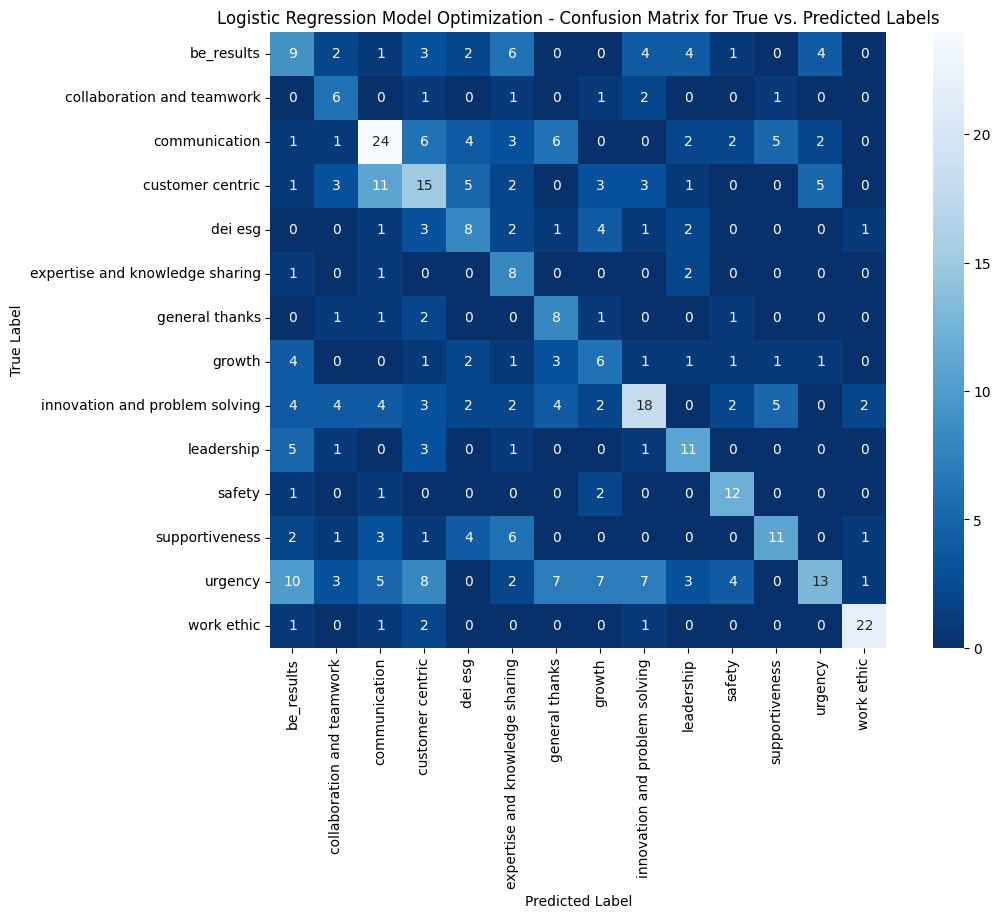

In [ ]:
# Create a label mapping dictionary
unique_labels = sorted(set(labels))
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Compute the confusion matrix
cm_log_reg = confusion_matrix(val_labels, test_preds)

# Plot the confusion matrix
fig = plt.figure(figsize=(12, 8))
sns.heatmap(cm_log_reg, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='horizontal')
plt.xticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='vertical')
plt.title("Logistic Regression Model Optimization - Confusion Matrix for True vs. Predicted Labels")
plt.show()

## XGBoost Bayesian Optimization Function with optuna to Train final model with best parameters

Here's what's different in this function compared to the logistic regression version above.

1. The XGBoost library (`xgboost`) is imported.
2. In the `objective` function, the search space for XGBoost hyperparameters is defined. This includes `max_depth`, `n_estimators`, `learning_rate`, `min_child_weight`, `gamma`, `reg_alpha`, and `reg_lambda`.
3. When creating the `XGBClassifier` instance inside the `objective` function, the hyperparameters are set based on the trial suggestions.
4. The `n_jobs` parameter is set to `-1` to use all available CPU cores for training.
5. The `tree_method` parameter is set to `'gpu_hist'` if CUDA is available, otherwise `'hist'` is used.
6. When training the best model on the entire dataset, the `XGBClassifier` instance is created with the best hyperparameters found by Optuna.


### **This function DOES NOT include the cost optimization

In [ ]:
## setup torch device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import optuna
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

## function to optimize xgboost model
def train_xgb_optuna(texts, labels, embedding_model, n_trials=60, n_folds=5):
    """
    Trains an XGBoost classification model using SentenceTransformer embeddings, with hyperparameter optimization
    using Optuna and stratified k-fold cross-validation.

    Args:
        texts: List of input texts.
        labels: List of corresponding labels.
        embedding_model: SentenceTransformer model.
        n_trials: Number of trials for hyperparameter optimization (default: 100).
        n_folds: Number of folds for cross-validation (default: 5).

    Returns:
        Best XGBoost model, best hyperparameters, and best cross-validation score.
    """

    # Create embeddings
    embeddings = embedding_model.encode(texts, show_progress_bar=True)

    def objective(trial):
        # Define the search space for XGBoost hyperparameters
        max_depth = trial.suggest_int('max_depth', 2, 10)
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        gamma = trial.suggest_float('gamma', 0, 1)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)

        # Initialize stratified k-fold cross-validation
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_scores = []

        # Perform stratified k-fold cross-validation
        for train_idx, val_idx in skf.split(embeddings, labels):
            X_train, X_val = embeddings[train_idx], embeddings[val_idx]
            y_train, y_val = np.array(labels)[train_idx], np.array(labels)[val_idx]

            # Create and train XGBoost model
            model = xgb.XGBClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                min_child_weight=min_child_weight,
                gamma=gamma,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                random_state=42,
                n_jobs=-1,
                tree_method='gpu_hist' if device.type == 'cuda' else 'hist'
            )
            model.fit(X_train, y_train)

            # Evaluate model on validation set
            y_pred = model.predict(X_val)
            cv_score = accuracy_score(y_val, y_pred)
            cv_scores.append(cv_score)

        # Return the mean cross-validation score as the objective to minimize
        return -np.mean(cv_scores)

    # Define a progress callback function — prints results after each trial run
    def progress_callback(study, trial):
        trial_params = trial.params
        trial_value = trial.value
        print(f"Trial {trial.number}: Parameters = {trial_params}, Value = {trial_value}")

    # Create Optuna study
    study = optuna.create_study(direction='minimize')

    # Perform hyperparameter optimization
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Train the best model on the entire dataset
    best_model = xgb.XGBClassifier(
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        random_state=42,
        n_jobs=-1,
        tree_method='gpu_hist' if device.type == 'cuda' else 'hist'
    )
    best_model.fit(embeddings, labels)

    return best_model, best_params, -study.best_value


### ONLY RUN THIS CODE IF USING FUNCTION ABOVE

In [ ]:
%%time
# Split the train_data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['text'], train_data['y_true'], test_size=0.2, random_state=42)

# Reset index of train_texts and val_texts to ensure they're continuous sequences
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True) # Reset index for val_texts as well

# 1. Train the logistic regression model with hyperparameter optimization
best_xgb_model, best_xgb_params, best_xgb_cv_score = train_xgb_optuna(train_texts, train_labels, embedding_model=model2) ## change embedding model

# 2. Print the best hyperparameters and best cross-validation score
print(f"Best hyperparameters: {best_xgb_params}")
print(f"Best cross-validation accuracy score: {best_xgb_cv_score:.4f}")

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

[I 2024-11-07 19:34:23,823] A new study created in memory with name: no-name-45e19796-0f06-4d05-a911-a8295298ce54
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [19:34:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set th

Best hyperparameters: {'max_depth': 2, 'n_estimators': 491, 'learning_rate': 0.03533245229496322, 'min_child_weight': 4, 'gamma': 0.38761509155786655, 'reg_alpha': 0.0009545139570235043, 'reg_lambda': 3.7763560536725695e-08}
Best cross-validation accuracy score: 0.3776
CPU times: user 1h 40min 35s, sys: 8.14 s, total: 1h 40min 44s
Wall time: 1h 40min 33s


In [ ]:
# 1. Train the XGBoost model with hyperparameter optimization
#best_xgb_model, best_xgb_params, best_xgb_cv_score = train_xgb_optuna(train_texts, train_labels, embedding_model=model2)

# 2. Print the best hyperparameters and best cross-validation score
print(f"Best hyperparameters: {best_xgb_params}")
print(f"Best cross-validation accuracy score: {best_xgb_cv_score:.4f}")

# Get the embeddings for the train and test sets
embedding_model = model2  # change embeddings for each test

# train embeddings
train_embeddings = embedding_model.encode(train_texts, show_progress_bar=True)
test_embeddings = embedding_model.encode(val_texts, show_progress_bar=True)

# Train the best XGBoost model on the train set
best_xgb_model = xgb.XGBClassifier(
    max_depth=best_xgb_params['max_depth'],
    n_estimators=best_xgb_params['n_estimators'],
    learning_rate=best_xgb_params['learning_rate'],
    min_child_weight=best_xgb_params['min_child_weight'],
    gamma=best_xgb_params['gamma'],
    reg_alpha=best_xgb_params['reg_alpha'],
    reg_lambda=best_xgb_params['reg_lambda'],
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist' if device.type == 'cuda' else 'hist'
)
## fit best model
best_xgb_model.fit(train_embeddings, train_labels)


# Get the predictions on the train and test sets
train_preds = best_xgb_model.predict(train_embeddings)
test_preds = best_xgb_model.predict(test_embeddings)

# Calculate the accuracy scores on the train and test sets
train_accuracy = accuracy_score(train_labels, train_preds)
test_accuracy = accuracy_score(val_labels, test_preds)

# Print the results
print(f"Train accuracy score: {train_accuracy:.4f}")
print(f"Test accuracy score: {test_accuracy:.4f}")

# Check the shapes
print("Shape of train_labels:", len(train_labels))
print("Shape of train_preds:", len(train_preds))
print("Shape of test_labels:", len(val_labels))
print("Shape of test_preds:", len(test_preds))

# Print the classification report on the test set
print("Classification report on test set:")
print(classification_report(val_labels, test_preds, target_names=list(set(labels))))

Best hyperparameters: {'max_depth': 2, 'n_estimators': 491, 'learning_rate': 0.03533245229496322, 'min_child_weight': 4, 'gamma': 0.38761509155786655, 'reg_alpha': 0.0009545139570235043, 'reg_lambda': 3.7763560536725695e-08}
Best cross-validation accuracy score: 0.3776


Batches:   0%|          | 0/55 [00:00<?, ?it/s]

Batches:   0%|          | 0/14 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:21:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Train accuracy score: 0.9852
Test accuracy score: 0.3568
Shape of train_labels: 1756
Shape of train_preds: 1756
Shape of test_labels: 440
Shape of test_preds: 440
Classification report on test set:
                                 precision    recall  f1-score   support

 innovation and problem solving       0.23      0.42      0.30        36
                 general thanks       0.36      0.33      0.35        12
     collaboration and teamwork       0.29      0.52      0.37        56
                         growth       0.33      0.24      0.28        49
                 supportiveness       0.28      0.22      0.24        23
                         safety       0.31      0.33      0.32        12
                     leadership       0.40      0.29      0.33        14
expertise and knowledge sharing       0.09      0.05      0.06        22
                     work ethic       0.42      0.48      0.45        52
               customer centric       0.67      0.09      0.16        2

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [22:22:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


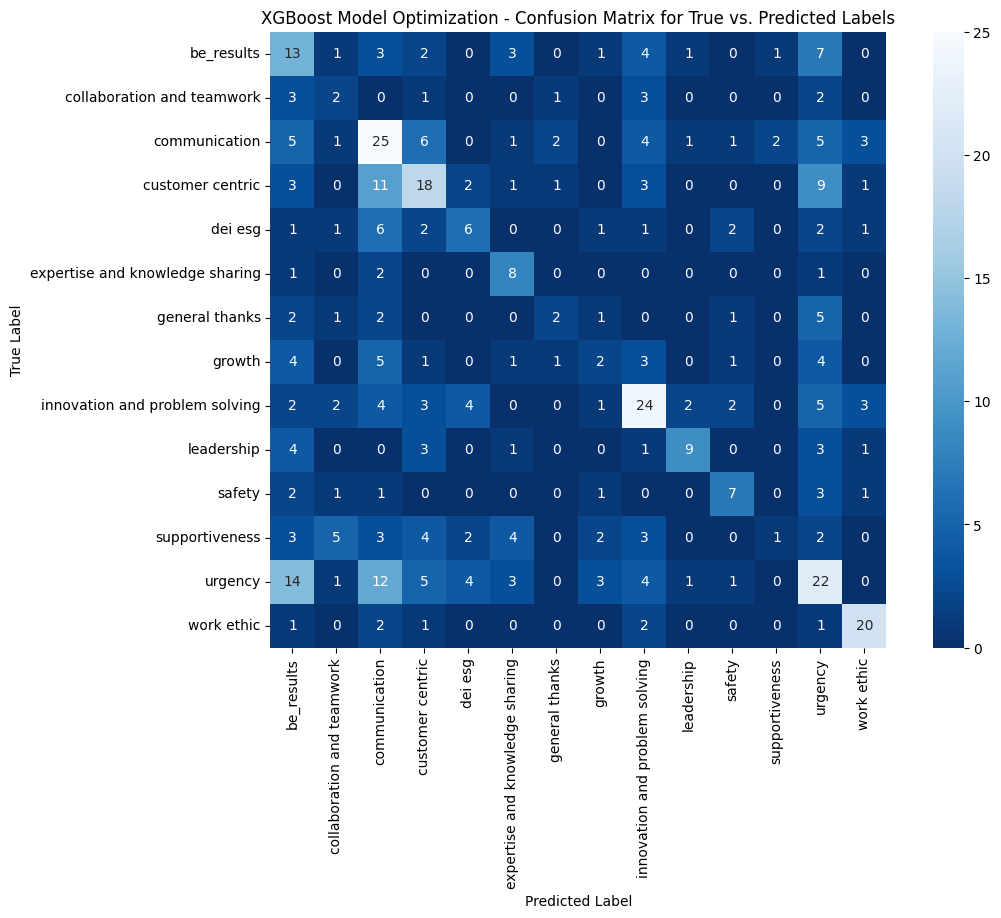

In [ ]:
# Create a label mapping dictionary
unique_labels = sorted(set(labels))
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Compute the confusion matrix
cm_xgb = confusion_matrix(val_labels, test_preds)

# Plot the confusion matrix
fig = plt.figure(figsize=(12, 8))
sns.heatmap(cm_xgb, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='horizontal')
plt.xticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='vertical')
plt.title("XGBoost Model Optimization - Confusion Matrix for True vs. Predicted Labels")
plt.show()

## XGBoost optimization function -- includes optimization for "cost-sensitive learning", "class-balanced loss", and "focal loss"
* These methods could potentially help with class imbalance.
* Here's what has been added or modified:

1. **Cost-sensitive learning**: The `sample_weight` parameter is set to the calculated `class_weights` when calling `model.fit(X_train, y_train, sample_weight=class_weights)`. This gives higher importance to instances from minority classes during training.

2. **Class-balanced loss**: A new line `sample_weight = [class_weights[label] for label in y_train]` calculates sample weights based on the class weights for each instance in the training set. Then, `model.fit(X_train, y_train, sample_weight=sample_weight)` is called to train the model using the class-balanced sample weights.

3. **Focal loss during evaluation**: The focal loss is calculated and appended to the `cv_scores` list using the same code as before.

4. **Cost-sensitive evaluation**: The cost-sensitive evaluation using the confusion matrix and accuracy is also included, as before.

By including all three techniques (cost-sensitive learning, class-balanced loss, and focal loss) in the objective function, the Optuna optimization process will try to find the best set of hyperparameters that optimize the model's performance on the imbalanced dataset.

After running the optimization, you can compare the performance of the models trained with each technique and choose the one that works best for your problem. Additionally, you can try combining these techniques (e.g., using both cost-sensitive learning and focal loss) to see if it further improves the model's performance.

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import numpy as np
import torch

## function to optimize xgboost model
def train_xgb_optuna(texts, labels, embedding_model, n_trials=10, n_folds=5):
    """
    Trains an XGBoost classification model using SentenceTransformer embeddings, with hyperparameter optimization
    using Optuna and stratified k-fold cross-validation.

    Args:
        texts: List of input texts.
        labels: List of corresponding labels.
        embedding_model: SentenceTransformer model.
        n_trials: Number of trials for hyperparameter optimization (default: 100).
        n_folds: Number of folds for cross-validation (default: 5).

    Returns:
        Best XGBoost model, best hyperparameters, and best cross-validation score.
    """

    # Create embeddings
    embeddings = embedding_model.encode(texts, show_progress_bar=True)

    # Check CUDA availability
    cuda_available = torch.cuda.is_available()

    def objective(trial):
        # Define the search space for XGBoost hyperparameters
        max_depth = trial.suggest_int('max_depth', 2, 10)
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True)
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
        gamma = trial.suggest_float('gamma', 0, 1)
        reg_alpha = trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True)
        reg_lambda = trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
        scale_pos_weight = trial.suggest_float('scale_pos_weight', 1e-3, 1e3, log=True)
        alpha = trial.suggest_float('alpha', 0.25, 0.75)  # Focal loss hyperparameter

        # Initialize stratified k-fold cross-validation
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_scores = []

        # Perform stratified k-fold cross-validation
        for train_idx, val_idx in skf.split(embeddings, labels):
            X_train, X_val = embeddings[train_idx], embeddings[val_idx]
            y_train, y_val = np.array(labels)[train_idx], np.array(labels)[val_idx]

            # Calculate class weights
            class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

            # Ensure sample weights have the same length as training data
            sample_weights = [class_weights[label] for label in y_train]

            # Create and train XGBoost model
            model = xgb.XGBClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                min_child_weight=min_child_weight,
                gamma=gamma,
                reg_alpha=reg_alpha,
                reg_lambda=reg_lambda,
                scale_pos_weight=scale_pos_weight,
                random_state=42,
                n_jobs=-1,
                tree_method='gpu_hist' if cuda_available else 'hist'
            )
            model.fit(X_train, y_train, sample_weight=sample_weights)

            # Evaluate model on validation set using cost-sensitive learning
            y_pred = model.predict(X_val)
            conf_matrix = confusion_matrix(y_val, y_pred)
            tn = conf_matrix[0, 0]
            fp = conf_matrix[0, 1:]
            fn = conf_matrix[1:, 0]
            tp = conf_matrix[1:, 1:].sum()
            cv_score = (tn + tp) / (tn + fp.sum() + fn.sum() + tp)  # Use accuracy as the cost function
            cv_scores.append(cv_score)

            # Optionally, you can use focal loss during evaluation
            y_pred_proba = model.predict_proba(X_val)
            focal_loss = -(((1 - y_pred_proba) ** gamma) * y_val.reshape(-1, 1) * np.log(y_pred_proba)).mean()
            cv_scores.append(-focal_loss)


        # Return the mean cross-validation score as the objective to minimize
        return -np.mean(cv_scores)

    # Define a progress callback function — prints results after each trial run
    def progress_callback(study, trial):
        trial_params = trial.params
        trial_value = trial.value
        print(f"Trial {trial.number}: Parameters = {trial_params}, Value = {trial_value}")


    # Create Optuna study
    study = optuna.create_study(direction='minimize')

    # Perform hyperparameter optimization
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Train the best model on the entire dataset
    best_model = xgb.XGBClassifier(
        max_depth=best_params['max_depth'],
        n_estimators=best_params['n_estimators'],
        learning_rate=best_params['learning_rate'],
        min_child_weight=best_params['min_child_weight'],
        gamma=best_params['gamma'],
        reg_alpha=best_params['reg_alpha'],
        reg_lambda=best_params['reg_lambda'],
        scale_pos_weight=best_params['scale_pos_weight'],
        random_state=42,
        n_jobs=-1,
        tree_method='gpu_hist' if cuda_available else 'hist'
    )
    best_model.fit(embeddings, labels)

    return best_model, best_params, -study.best_value

In [ ]:
# 1. Train the XGBoost model with hyperparameter optimization
best_xgb_model, best_xgb_params, best_xgb_cv_score = train_xgb_optuna(train_texts, train_labels, embedding_model=model2)

# 2. Print the best hyperparameters and best cross-validation score
print(f"Best hyperparameters: {best_xgb_params}")
print(f"Best cross-validation accuracy score: {best_xgb_cv_score:.4f}")

# Get the embeddings for the train and test sets
embedding_model = model1  # change embeddings for each test

# train embeddings
train_embeddings = embedding_model.encode(train_texts, show_progress_bar=True)
test_embeddings = embedding_model.encode(val_texts, show_progress_bar=True)

# Train the best XGBoost model on the train set
best_xgb_model = xgb.XGBClassifier(
    max_depth=best_xgb_params['max_depth'],
    n_estimators=best_xgb_params['n_estimators'],
    learning_rate=best_xgb_params['learning_rate'],
    min_child_weight=best_xgb_params['min_child_weight'],
    gamma=best_xgb_params['gamma'],
    reg_alpha=best_xgb_params['reg_alpha'],
    reg_lambda=best_xgb_params['reg_lambda'],
    random_state=42,
    n_jobs=-1,
    tree_method='gpu_hist' if cuda_available else 'hist'
)
## fit best model
best_xgb_model.fit(train_embeddings, train_labels)


# Get the predictions on the train and test sets
train_preds = best_xgb_model.predict(train_embeddings)
test_preds = best_xgb_model.predict(test_embeddings)

# Calculate the accuracy scores on the train and test sets
train_accuracy = accuracy_score(train_labels, train_preds)
test_accuracy = accuracy_score(test_labels, test_preds)

# Print the results
print(f"Train accuracy score: {train_accuracy:.4f}")
print(f"Test accuracy score: {test_accuracy:.4f}")

# Check the shapes
print("Shape of train_labels:", len(train_labels))
print("Shape of train_preds:", len(train_preds))
print("Shape of test_labels:", len(test_labels))
print("Shape of test_preds:", len(test_preds))

# Print the classification report on the test set
print("Classification report on test set:")
print(classification_report(test_labels, test_preds, target_names=list(set(labels))))

Batches:   0%|          | 0/55 [00:00<?, ?it/s]

[I 2024-11-06 23:18:32,925] A new study created in memory with name: no-name-64fb400e-5d6e-4129-8f67-0dff4a5791d0
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:18:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:18:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:18:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/us

In [ ]:
# Get the predictions on the train and test sets
train_preds = best_xgb_model.predict(train_embeddings)
test_preds = best_xgb_model.predict(test_embeddings)

# Calculate the accuracy scores on the train and test sets
train_accuracy = accuracy_score(train_labels, train_preds)
test_accuracy = accuracy_score(val_labels, test_preds)

# Print the results
print(f"Train accuracy score: {train_accuracy:.4f}")
print(f"Test accuracy score: {test_accuracy:.4f}")

# Check the shapes
print("Shape of train_labels:", len(train_labels))
print("Shape of train_preds:", len(train_preds))
print("Shape of test_labels:", len(val_labels))
print("Shape of test_preds:", len(test_preds))

# Print the classification report on the test set
print("Classification report on test set:")
print(classification_report(val_labels, test_preds, target_names=list(set(labels))))

Train accuracy score: 0.5951
Test accuracy score: 0.2773
Shape of train_labels: 1756
Shape of train_preds: 1756
Shape of test_labels: 440
Shape of test_preds: 440
Classification report on test set:
                                 precision    recall  f1-score   support

     collaboration and teamwork       0.25      0.36      0.30        36
                        urgency       0.12      0.08      0.10        12
 innovation and problem solving       0.29      0.55      0.38        56
                 general thanks       0.26      0.22      0.24        49
                         growth       0.12      0.04      0.06        23
                  communication       0.18      0.17      0.17        12
               customer centric       0.00      0.00      0.00        14
                     be_results       0.00      0.00      0.00        22
                         safety       0.24      0.42      0.31        52
                        dei esg       0.25      0.05      0.08        2

In [ ]:
# Create a label mapping dictionary
unique_labels = sorted(set(labels))
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Compute the confusion matrix
cm_xgb = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
fig = plt.figure(figsize=(12, 8))
sns.heatmap(cm_xgb, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='horizontal')
plt.xticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='vertical')
plt.title("XGBoost Model Optimization - Confusion Matrix for True vs. Predicted Labels")
plt.show()

## SVM Bayesian Optimization Function with Optuna to Train final model with best parameters

In [ ]:
import optuna
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

## SVM function
def train_svm_optuna(texts, labels, embedding_model, n_trials=100, n_folds=5):
    """
    Trains an SVM classification model using SentenceTransformer embeddings, with hyperparameter optimization
    using Optuna and stratified k-fold cross-validation.

    Args:
        texts: List of input texts.
        labels: List of corresponding labels.
        embedding_model: SentenceTransformer model.
        n_trials: Number of trials for hyperparameter optimization (default: 100).
        n_folds: Number of folds for cross-validation (default: 5).

    Returns:
        Best SVM model, best hyperparameters, and best cross-validation score.
    """

    # Create embeddings
    embeddings = embedding_model.encode(texts, show_progress_bar=True)

    def objective(trial):
        # Define the search space for SVM hyperparameters
        C = trial.suggest_float('C', 1e-5, 1e5, log=True)
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
        gamma = trial.suggest_float('gamma', 1e-5, 1e-1, log=True) if kernel == 'rbf' else 'auto'
        degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
        coef0 = trial.suggest_float('coef0', 0, 1) if kernel == 'poly' or kernel == 'sigmoid' else 0.0

        # Initialize stratified k-fold cross-validation
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_scores = []

        # Perform stratified k-fold cross-validation
        for train_idx, val_idx in skf.split(embeddings, labels):
            X_train, X_val = embeddings[train_idx], embeddings[val_idx]
            y_train, y_val = np.array(labels)[train_idx], np.array(labels)[val_idx]

            # Create and train SVM model
            model = SVC(
                C=C,
                kernel=kernel,
                gamma=gamma,
                degree=degree,
                coef0=coef0,
                random_state=42
            )
            model.fit(X_train, y_train)

            # Evaluate model on validation set
            y_pred = model.predict(X_val)
            cv_score = accuracy_score(y_val, y_pred)
            cv_scores.append(cv_score)

        # Return the mean cross-validation score as the objective to minimize
        return -np.mean(cv_scores)

    # Create Optuna study
    study = optuna.create_study(direction='minimize')

    # Perform hyperparameter optimization
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Train the best model on the entire dataset
    best_model = SVC(
        C=best_params['C'],
        kernel=best_params['kernel'],
        gamma=best_params['gamma'] if best_params['kernel'] == 'rbf' else 'auto',
        degree=best_params['degree'] if best_params['kernel'] == 'poly' else 3,
        coef0=best_params['coef0'] if best_params['kernel'] == 'poly' or best_params['kernel'] == 'sigmoid' else 0.0,
        random_state=42
    )
    best_model.fit(embeddings, labels)

    return best_model, best_params, -study.best_value




In [ ]:
%%time
# Split the train_data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['text'], train_data['y_true'], test_size=0.2, random_state=42)

# Reset index of train_texts and val_texts to ensure they're continuous sequences
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True) # Reset index for val_texts as well

# 1. Train SVM model with hyperparameter optimization
best_svm_model, best_svm_params, best_svm_cv_score = train_svm_optuna(train_texts, train_labels, embedding_model=model1) ## change embedding model

# 2. Print the best hyperparameters and best cross-validation score
print(f"Best hyperparameters: {best_params}")
print(f"Best cross-validation accuracy score: {best_cv_score:.4f}")

In [ ]:
# Get the embeddings for the train and test sets
train_embeddings = embedding_model.encode(train_texts, show_progress_bar=True)
test_embeddings = embedding_model.encode(val_texts, show_progress_bar=True)

# Train the best SVM model on the train set
best_svm_model.fit(train_embeddings, train_labels)

# Get the predictions on the train and test sets
train_preds = best_svm_model.predict(train_embeddings)
test_preds = best_svm_model.predict(test_embeddings)

# Calculate the accuracy scores on the train and test sets
train_accuracy = accuracy_score(train_labels, train_preds)
test_accuracy = accuracy_score(test_labels, test_preds)

# Print the results
print(f"Train accuracy score: {train_accuracy:.4f}")
print(f"Test accuracy score: {test_accuracy:.4f}")

# Check the shapes
print("Shape of train_labels:", len(train_labels))
print("Shape of train_preds:", len(train_preds))
print("Shape of test_labels:", len(test_labels))
print("Shape of test_preds:", len(test_preds))

# Print the classification report on the test set
print("Classification report on test set:")
print(classification_report(test_labels, test_preds, target_names=list(set(labels))))

In [ ]:
# Create a label mapping dictionary
unique_labels = sorted(set(labels))
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Compute the confusion matrix
cm_svm = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
fig = plt.figure(figsize=(12, 8))
sns.heatmap(cm_svm, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='horizontal')
plt.xticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='vertical')
plt.title("SVM Model Optimization - Confusion Matrix for True vs. Predicted Labels")
plt.show()

### Naive Bayes Bayesian Optimization Function with Optuna to Train final model with best parameters

In [ ]:
import optuna
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score


## naive bayes optuna function
def train_nb_optuna(texts, labels, embedding_model, n_trials=100, n_folds=5):
    """
    Trains a Naive Bayes classification model using SentenceTransformer embeddings, with hyperparameter optimization
    using Optuna and stratified k-fold cross-validation.

    Args:
        texts: List of input texts.
        labels: List of corresponding labels.
        embedding_model: SentenceTransformer model.
        n_trials: Number of trials for hyperparameter optimization (default: 100).
        n_folds: Number of folds for cross-validation (default: 5).

    Returns:
        Best Naive Bayes model, best hyperparameters, and best cross-validation score.
    """

    # Create embeddings
    embeddings = embedding_model.encode(texts, show_progress_bar=True)

    def objective(trial):
        # Define the search space for Naive Bayes hyperparameters
        alpha = trial.suggest_float('alpha', 1e-5, 1e5, log=True)
        fit_prior = trial.suggest_categorical('fit_prior', [True, False])

        # Initialize stratified k-fold cross-validation
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
        cv_scores = []

        # Perform stratified k-fold cross-validation
        for train_idx, val_idx in skf.split(embeddings, labels):
            X_train, X_val = embeddings[train_idx], embeddings[val_idx]
            y_train, y_val = np.array(labels)[train_idx], np.array(labels)[val_idx]

            # Create and train Naive Bayes model
            model = MultinomialNB(alpha=alpha, fit_prior=fit_prior)
            model.fit(X_train, y_train)

            # Evaluate model on validation set
            y_pred = model.predict(X_val)
            cv_score = accuracy_score(y_val, y_pred)
            cv_scores.append(cv_score)

        # Return the mean cross-validation score as the objective to minimize
        return -np.mean(cv_scores)

    # Create Optuna study
    study = optuna.create_study(direction='minimize')

    # Perform hyperparameter optimization
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Train the best model on the entire dataset
    best_model = MultinomialNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'])
    best_model.fit(embeddings, labels)

    return best_model, best_params, -study.best_value

In [ ]:
%%time
# Split the train_data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(train_data['text'], train_data['y_true'], test_size=0.2, random_state=42)

# Reset index of train_texts and val_texts to ensure they're continuous sequences
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True) # Reset index for val_texts as well

# 1. Train NB model with hyperparameter optimization
best_nb_model, best_nb_params, best_nb_cv_score = train_nb_optuna(train_texts, train_labels, embedding_model=model1) ## change embedding model

# 2. Print the best hyperparameters and best cross-validation score
print(f"Naive Bayes - Best hyperparameters: {best_params}")
print(f"Naive Bayes - Best cross-validation accuracy score: {best_cv_score:.4f}")

In [ ]:
# Get the embeddings for the train and test sets
train_embeddings = embedding_model.encode(train_texts, show_progress_bar=True)
test_embeddings = embedding_model.encode(val_texts, show_progress_bar=True)

# Train the best NB model on the train set
best_nb_model.fit(train_embeddings, train_labels)

# Get the predictions on the train and test sets
train_preds = best_nb_model.predict(train_embeddings)
test_preds = best_nb_model.predict(test_embeddings)

# Calculate the accuracy scores on the train and test sets
train_accuracy = accuracy_score(train_labels, train_preds)
test_accuracy = accuracy_score(test_labels, test_preds)

# Print the results
print(f"Naive Bayes - Train accuracy score: {train_accuracy:.4f}")
print(f"Naive Bayes - Test accuracy score: {test_accuracy:.4f}")

# Check the shapes
print("Shape of train_labels:", len(train_labels))
print("Shape of train_preds:", len(train_preds))
print("Shape of test_labels:", len(test_labels))
print("Shape of test_preds:", len(test_preds))

# Print the classification report on the test set
print("Naive Bayes - Classification report on test set:")
print(classification_report(test_labels, test_preds, target_names=list(set(labels))))

In [ ]:
# Create a label mapping dictionary
unique_labels = sorted(set(labels))
label_mapping = {label: i for i, label in enumerate(unique_labels)}

# Compute the confusion matrix
cm_nb = confusion_matrix(test_labels, test_preds)

# Plot the confusion matrix
fig = plt.figure(figsize=(12, 8))
sns.heatmap(cm_nb, annot=True, square=True, cmap='Blues_r')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.yticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='horizontal')
plt.xticks([i + 0.5 for i in range(len(unique_labels))], unique_labels, rotation='vertical')
plt.title("NB - Model Optimization - Confusion Matrix for True vs. Predicted Labels")
plt.show()